https://www.kaggle.com/bertcarremans/data-preparation-exploration

#Introduction

This notebook aims at getting a good insight in the data for the PorteSeguro competition. Besides that, it gives some tips and tricks to prepare your data for modeling. The notebook consists of the following main sections:

Visual inspection of your data

Defining the metadata

Descriptive statistics

Handling imbalanced classes

Data quality checks

Exploratory data visualization

Feature engineering

Feature selection

Feature scaling

# Loading packages

In [ ]:
%matplotlib inline
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#from imblearn.datasets import fetch_datasets
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from xgboost import XGBClassifier

from imblearn.metrics import geometric_mean_score

from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle

pd.set_option('display.max_columns', 100)

import joblib # to save sklearn model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
! pip install h2o

     |████████████████████████████████| 129.3MB 92kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.1-py2.py3-none-any.whl size=129358602 sha256=f9fbc6f4bf47bdf02f811ee1dbf5b03071793f1765c1a5fc0be579b68793d78a
  Stored in directory: /root/.cache/pip/wheels/33/ac/52/165c35d747abdb629c3c9fb7e087f360c662d8cb58824caed8
Successfully built h2o


In [ ]:
import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpt90jer60
  JVM stdout: /tmp/tmpt90jer60/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpt90jer60/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_unknownUser_os9r65
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


# Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro’s Safe Driver Prediction/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro’s Safe Driver Prediction/test.csv')

Data at first sight

Here is an excerpt of the the data description for the competition:

Features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc).

Feature names include the postfix bin to indicate binary features and cat to indicate categorical features.

Features without these designations are either continuous or ordinal.

Values of -1 indicate that the feature was missing from the observation.

The target columns signifies whether or not a claim was filed for that policy holder.

Ok, that's important information to get us started. Let's have a quick look at the first and last rows to confirm all of this.

In [ ]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [ ]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


In [ ]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


In [ ]:
test.tail()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
892811,1488022,0,1,6,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0.5,0.3,1.048809,0,1,-1,8,0,14,0,1,0,1,18,2,0.565685,1.528774,0.565685,3.605551,0.3,0.4,0.9,1,1,7,3,10,3,10,4,2,3,4,0,1,0,0,1,0
892812,1488023,5,3,5,1,0,0,0,1,0,0,0,0,0,0,11,1,0,0,0.7,1.0,1.246495,8,1,-1,0,0,10,1,0,0,1,83,2,0.424264,1.040567,0.418569,3.741657,0.3,0.2,0.6,1,3,7,3,10,4,9,6,2,2,11,0,0,1,1,0,0
892813,1488024,0,1,5,0,0,1,0,0,0,0,0,0,0,0,5,0,0,1,0.4,0.0,0.609303,11,1,-1,0,-1,11,1,0,1,1,17,2,0.374166,0.968992,0.390384,3.741657,0.3,0.3,0.9,2,1,10,4,8,2,8,5,2,2,11,0,1,1,0,0,0
892814,1488025,6,1,5,1,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.6,0.6,0.920937,10,0,-1,0,1,10,1,1,0,1,28,3,0.387298,0.725125,0.378153,2.645751,0.1,0.1,0.3,1,1,9,2,10,1,8,1,1,2,7,1,1,0,0,0,0
892815,1488026,7,1,4,1,0,0,0,0,1,0,0,0,0,0,12,1,0,0,0.9,0.8,0.992157,9,1,1,0,0,4,1,1,2,1,48,1,0.316228,0.637175,0.296648,3.316625,0.4,0.4,0.2,3,4,7,2,8,4,15,5,2,2,7,0,1,1,1,0,0


We indeed see the following

binary variables

categorical variables of which the category values are integers

other variables with integer or float values

variables with -1 representing missing values

the target variable and an ID variable

Let's look at the number of rows and columns in the train data.

In [ ]:
train.shape

(595212, 59)

In [ ]:
test.shape

(892816, 58)

We have 59 variables and 595.212 rows. Let's see if we have the same number of variables in the test data.

Let's see if there are duplicate rows in the training data.

In [ ]:
train.drop_duplicates()
train.shape

(595212, 59)

In [ ]:
test.drop_duplicates()
test.shape

(892816, 58)

No duplicate rows, so that's fine.

We are missing one variable in the test set, but this is the target variable. So that's fine.

Let's now invesigate how many variables of each type we have.

So later on we can create dummy variables for the 14 categorical variables. The bin variables are already binary and do not need dummification.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              892816 non-null  int64  
 1   ps_ind_01       892816 non-null  int64  
 2   ps_ind_02_cat   892816 non-null  int64  
 3   ps_ind_03       892816 non-null  int64  
 4   ps_ind_04_cat   892816 non-null  int64  
 5   ps_ind_05_cat   892816 non-null  int64  
 6   ps_ind_06_bin   892816 non-null  int64  
 7   ps_ind_07_bin   892816 non-null  int64  
 8   ps_ind_08_bin   892816 non-null  int64  
 9   ps_ind_09_bin   892816 non-null  int64  
 10  ps_ind_10_bin   892816 non-null  int64  
 11  ps_ind_11_bin   892816 non-null  int64  
 12  ps_ind_12_bin   892816 non-null  int64  
 13  ps_ind_13_bin   892816 non-null  int64  
 14  ps_ind_14       892816 non-null  int64  
 15  ps_ind_15       892816 non-null  int64  
 16  ps_ind_16_bin   892816 non-null  int64  
 17  ps_ind_17_

Again, with the info() method we see that the data type is integer or float. No null values are present in the data set. That's normal because missing values are replaced by -1. We'll look into that later.

# Metadata
To facilitate the data management, we'll store meta-information about the variables in a DataFrame. This will be helpful when we want to select specific variables for analysis, visualization, modeling, ...

Concretely we will store:

role: input, ID, target

level: nominal, interval, ordinal, binary

keep: True or False

dtype: int, float, str

In [ ]:
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type 
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [ ]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [ ]:
data_test = []
for col in test.columns:
    # Defining the role
    if col == 'id':
        role_test = 'id'
    else:
        role_test = 'input'
         
    # Defining the level
    if 'bin' in col:
        level_test = 'binary'
    elif 'cat' in col or col == 'id':
        level_test = 'nominal'
    elif test[col].dtype == float:
        level_test = 'interval'
    elif test[col].dtype == int:
        level_test = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep_test = True
    if col == 'id':
        keep_test = False
    
    # Defining the data type 
    dtype_test = test[col].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    col_dict = {
        'varname': col,
        'role_test': role_test,
        'level_test': level_test,
        'keep_test': keep_test,
        'dtype_test': dtype_test
    }
    data_test.append(col_dict)
    
meta_test = pd.DataFrame(data_test, columns=['varname', 'role_test', 'level_test', 'keep_test', 'dtype'])
meta_test.set_index('varname', inplace=True)

In [ ]:
meta_test

,role_test,level_test,keep_test,dtype
varname,,,,
id,id,nominal,False,NaN
ps_ind_01,input,ordinal,True,NaN
ps_ind_02_cat,input,nominal,True,NaN
ps_ind_03,input,ordinal,True,NaN
ps_ind_04_cat,input,nominal,True,NaN
ps_ind_05_cat,input,nominal,True,NaN
ps_ind_06_bin,input,binary,True,NaN
ps_ind_07_bin,input,binary,True,NaN
ps_ind_08_bin,input,binary,True,NaN


Example to extract all nominal variables that are not dropped

In [ ]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [ ]:
meta_test[(meta_test.level_test == 'nominal') & (meta_test['keep_test'])].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

Below the number of variables per role and level are displayed.

In [ ]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


In [ ]:
pd.DataFrame({'count' : meta_test.groupby(['role_test', 'level_test'])['role_test'].size()}).reset_index()

,role_test,level_test,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16


# Descriptive statistics

We can also apply the describe method on the dataframe. However, it doesn't make much sense to calculate the mean, std, ... on categorical variables and the id variable. We'll explore the categorical variables visually later.

Thanks to our meta file we can easily select the variables on which we want to compute the descriptive statistics. To keep things clear, we'll do this per data type.

## Interval variables

In [ ]:
v_test = meta[(meta.level == 'interval') & (meta.keep)].index
test[v_test].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,0.611057,0.439868,0.551740,0.379957,0.813637,0.276431,3.068325,0.449632,0.450453,0.450054
std,0.287699,0.404678,0.794023,0.058385,0.224779,0.356835,0.729005,0.287213,0.287373,0.287254
min,0.000000,0.000000,-1.000000,0.141421,0.275778,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.524404,0.316228,0.671234,0.333916,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.721110,0.374166,0.766081,0.368782,3.316625,0.400000,0.500000,0.400000
75%,0.900000,0.600000,1.002185,0.400000,0.906132,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.423517,1.264911,4.031301,0.636396,3.741657,0.900000,0.900000,0.900000


In [ ]:
v_test = meta_test[(meta_test['level_test'] == 'interval') & (meta_test['keep_test'])].index
test[v_test].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,0.611057,0.439868,0.551740,0.379957,0.813637,0.276431,3.068325,0.449632,0.450453,0.450054
std,0.287699,0.404678,0.794023,0.058385,0.224779,0.356835,0.729005,0.287213,0.287373,0.287254
min,0.000000,0.000000,-1.000000,0.141421,0.275778,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.524404,0.316228,0.671234,0.333916,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.721110,0.374166,0.766081,0.368782,3.316625,0.400000,0.500000,0.400000
75%,0.900000,0.600000,1.002185,0.400000,0.906132,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.423517,1.264911,4.031301,0.636396,3.741657,0.900000,0.900000,0.900000


reg variables

only ps_reg_03 has missing values

the range (min to max) differs between the variables. We could apply scaling (e.g. StandardScaler), but it depends on the classifier we will want to use.

car variables

ps_car_12 and ps_car_15 have missing values

again, the range differs and we could apply scaling.

calc variables

no missing values

this seems to be some kind of ratio as the maximum is 0.9

all three _calc variables have very similar distributions

Overall, we can see that the range of the interval variables is rather small. Perhaps some transformation (e.g. log) is already applied in order to anonymize the data?

## Ordinal variables

In [ ]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [ ]:
v_test = meta_test[(meta_test['level_test'] == 'ordinal') & (meta_test['keep_test'])].index
test[v_test].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,1.902371,4.413734,0.012383,7.296862,2.346606,2.371390,1.885328,7.687805,3.009537,9.225854,2.338538,8.443167,5.438478,1.440265,2.875013,7.540367
std,1.986503,2.700149,0.127251,3.541948,0.831666,1.116953,1.136763,1.333521,1.415155,1.460560,1.248601,2.906361,2.330081,1.200620,1.694072,2.745882
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,20.000000,11.000000,15.000000,28.000000


Only one missing variable: ps_car_11

We could apply scaling to deal with the different ranges


## Binary variables

In [ ]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
v_test = meta_test[(meta_test['level_test'] == 'binary') & (meta_test['keep_test'])].index
test[v_test].describe()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,0.393246,0.257191,0.163659,0.185905,0.000373,0.001595,0.009376,0.001039,0.660591,0.120399,0.154973,0.123720,0.627756,0.554660,0.287796,0.349344,0.152428
std,0.488471,0.437086,0.369966,0.389030,0.019309,0.039905,0.096375,0.032223,0.473509,0.325428,0.361879,0.329262,0.483403,0.497004,0.452736,0.476763,0.359435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


A priori in the train data is 3.645%, which is strongly imbalanced.

From the means we can conclude that for most variables the value is zero in most cases.

# Handling imbalanced classes

As we mentioned above the proportion of records with target=1 is far less than target=0. This can lead to a model that has great accuracy but does have any added value in practice. Two possible strategies to deal with this problem are:

oversampling records with target=1

undersampling records with target=0

There are many more strategies of course and MachineLearningMastery.com gives a nice overview. As we have a rather large training set, we can go for undersampling.

In [ ]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=1612, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [ ]:
# desired_apriori_test=0.10

# # Get the indices per target value
# idx_0_test = test[test.target == 0].index
# idx_1_test = test[test.target == 1].index

# # Get original number of records per target value
# nb_0 = len(test.loc[idx_0])
# nb_1 = len(test.loc[idx_1])

# # Calculate the undersampling rate and resulting number of records with target=0
# undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
# undersampled_nb_0 = int(undersampling_rate*nb_0)
# print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
# print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# # Randomly select records with target=0 to get at the desired a priori
# undersampled_idx = shuffle(idx_0, random_state=1612, n_samples=undersampled_nb_0)

# # Construct list with remaining indices
# idx_list = list(undersampled_idx) + list(idx_1)

# # Return undersample data frame
# test = test.loc[idx_list].reset_index(drop=True)

## Data Quality Checks


### Checking missing values

Missings are represented as -1

In [ ]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 107 records (0.05%) with missing values
Variable ps_ind_04_cat has 50 records (0.02%) with missing values
Variable ps_ind_05_cat has 2266 records (1.04%) with missing values
Variable ps_reg_03 has 38675 records (17.83%) with missing values
Variable ps_car_01_cat has 59 records (0.03%) with missing values
Variable ps_car_02_cat has 3 records (0.00%) with missing values
Variable ps_car_03_cat has 148838 records (68.61%) with missing values
Variable ps_car_05_cat has 96119 records (44.31%) with missing values
Variable ps_car_07_cat has 4439 records (2.05%) with missing values
Variable ps_car_09_cat has 226 records (0.10%) with missing values
Variable ps_car_11 has 3 records (0.00%) with missing values
Variable ps_car_14 has 15636 records (7.21%) with missing values
In total, there are 12 variables with missing values


ps_car_03_cat and ps_car_05_cat have a large proportion of records with missing values. Remove these variables.

For the other categorical variables with missing values, we can leave the missing value -1 as such.

ps_reg_03 (continuous) has missing values for 18% of all records. Replace by the mean.

ps_car_11 (ordinal) has only 5 records with misisng values. Replace by the mode.

ps_car_12 (continuous) has only 1 records with missing value. Replace by the mean.

ps_car_14 (continuous) has missing values for 7% of all records. Replace by the mean.

In [ ]:
vars_with_missing_test = []

for col in test.columns:
    missings_test = test[test[col] == -1][col].count()
    if missings_test > 0:
        vars_with_missing_test.append(col)
        missings_perc_test = missings_test/test.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(col, missings_test, missings_perc_test))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing_test)))

Variable ps_ind_02_cat has 307 records (0.03%) with missing values
Variable ps_ind_04_cat has 145 records (0.02%) with missing values
Variable ps_ind_05_cat has 8710 records (0.98%) with missing values
Variable ps_reg_03 has 161684 records (18.11%) with missing values
Variable ps_car_01_cat has 160 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 616911 records (69.10%) with missing values
Variable ps_car_05_cat has 400359 records (44.84%) with missing values
Variable ps_car_07_cat has 17331 records (1.94%) with missing values
Variable ps_car_09_cat has 877 records (0.10%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 63805 records (7.15%) with missing values
In total, there are 12 variables with missing values


ps_car_03_cat and ps_car_05_cat have a large proportion of records with missing values. Remove these variables.

For the other categorical variables with missing values, we can leave the missing value -1 as such.

ps_ind_02_cat, ps_ind_04_cat, ps_ind_05_cat, ps_car_01_cat, ps_car_02_cat, ps_car_07_cat, ps_car_09_cat are replaced by the mode.

ps_reg_03 (continuous) has missing values for 18% of all records. Replace by the mean.

ps_car_11 (ordinal) has only 1 record with missing values. Replace by the mode.

ps_car_14 (continuous) has missing values for 7% of all records. Replace by the mean.

In [ ]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,1303831,0,1,1,4,0,0,0,0,1,0,0,0,0,0,0,6,1,0,0,0.7,1.7,1.300240,11,0,-1,9,-1,13,1,1,2,1,104,3,0.446990,1.293116,0.454973,3.464102,0.0,0.6,0.7,3,2,9,2,9,1,9,7,3,2,9,0,1,0,0,0,0
1,471100,0,2,2,6,1,0,0,1,0,0,0,0,0,0,0,3,1,0,0,0.8,0.1,0.725862,10,1,-1,0,0,1,1,1,0,1,74,2,0.374166,0.815378,0.371618,3.605551,0.0,0.8,0.2,2,1,6,4,10,2,6,6,1,1,11,1,1,0,0,0,0
2,619926,0,5,2,1,1,6,0,0,0,1,0,0,0,0,0,4,1,0,0,0.1,0.5,-1.000000,4,1,-1,0,1,1,1,1,0,1,70,3,0.374166,0.722956,0.393700,2.828427,0.1,0.1,0.9,4,2,7,2,10,2,7,6,0,3,7,0,1,1,0,1,0
3,963922,0,3,1,5,0,0,0,0,1,0,0,0,0,0,0,10,0,0,0,0.6,0.6,0.871421,6,1,-1,0,0,14,1,1,0,1,60,1,0.316228,0.640280,0.347275,3.316625,0.1,0.2,0.0,3,1,8,0,8,2,7,1,1,4,15,0,0,1,0,0,0
4,1201104,0,1,1,8,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.3,0.3,-1.000000,7,1,-1,0,-1,0,1,1,0,1,62,3,0.400000,0.758492,0.382623,2.645751,0.6,0.8,0.3,3,1,7,2,11,0,13,2,0,7,5,0,0,1,0,1,0


In [ ]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


In [ ]:
train = train.replace([-1], np.nan)
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,1303831,0,1,1.0,4,0.0,0.0,0,0,1,0,0,0,0,0,0,6,1,0,0,0.7,1.7,1.300240,11.0,0.0,NaN,9,NaN,13,1.0,1,2.0,1,104,3.0,0.446990,1.293116,0.454973,3.464102,0.0,0.6,0.7,3,2,9,2,9,1,9,7,3,2,9,0,1,0,0,0,0
1,471100,0,2,2.0,6,1.0,0.0,0,1,0,0,0,0,0,0,0,3,1,0,0,0.8,0.1,0.725862,10.0,1.0,NaN,0,0.0,1,1.0,1,0.0,1,74,2.0,0.374166,0.815378,0.371618,3.605551,0.0,0.8,0.2,2,1,6,4,10,2,6,6,1,1,11,1,1,0,0,0,0
2,619926,0,5,2.0,1,1.0,6.0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.1,0.5,NaN,4.0,1.0,NaN,0,1.0,1,1.0,1,0.0,1,70,3.0,0.374166,0.722956,0.393700,2.828427,0.1,0.1,0.9,4,2,7,2,10,2,7,6,0,3,7,0,1,1,0,1,0
3,963922,0,3,1.0,5,0.0,0.0,0,0,1,0,0,0,0,0,0,10,0,0,0,0.6,0.6,0.871421,6.0,1.0,NaN,0,0.0,14,1.0,1,0.0,1,60,1.0,0.316228,0.640280,0.347275,3.316625,0.1,0.2,0.0,3,1,8,0,8,2,7,1,1,4,15,0,0,1,0,0,0
4,1201104,0,1,1.0,8,0.0,0.0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.3,0.3,NaN,7.0,1.0,NaN,0,NaN,0,1.0,1,0.0,1,62,3.0,0.400000,0.758492,0.382623,2.645751,0.6,0.8,0.3,3,1,7,2,11,0,13,2,0,7,5,0,0,1,0,1,0


In [ ]:
test = test.replace([-1], np.nan)
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1.0,8,1.0,0.0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7.0,1.0,NaN,0,NaN,1,1.0,1,2.0,1,65,1.0,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2.0,5,1.0,0.0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4.0,1.0,NaN,0,0.0,11,1.0,1,0.0,1,103,1.0,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1.0,3,0.0,0.0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,29,3.0,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1.0,6,0.0,0.0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,NaN,7.0,1.0,NaN,0,NaN,1,1.0,1,2.0,1,40,2.0,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1.0,7,0.0,0.0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11.0,1.0,NaN,0,NaN,11,1.0,1,2.0,1,101,3.0,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


In [ ]:
train.isna().sum()

id                     0
target                 0
ps_ind_01              0
ps_ind_02_cat        107
ps_ind_03              0
ps_ind_04_cat         50
ps_ind_05_cat       2266
ps_ind_06_bin          0
ps_ind_07_bin          0
ps_ind_08_bin          0
ps_ind_09_bin          0
ps_ind_10_bin          0
ps_ind_11_bin          0
ps_ind_12_bin          0
ps_ind_13_bin          0
ps_ind_14              0
ps_ind_15              0
ps_ind_16_bin          0
ps_ind_17_bin          0
ps_ind_18_bin          0
ps_reg_01              0
ps_reg_02              0
ps_reg_03          38675
ps_car_01_cat         59
ps_car_02_cat          3
ps_car_03_cat     148838
ps_car_04_cat          0
ps_car_05_cat      96119
ps_car_06_cat          0
ps_car_07_cat       4439
ps_car_08_cat          0
ps_car_09_cat        226
ps_car_10_cat          0
ps_car_11_cat          0
ps_car_11              3
ps_car_12              0
ps_car_13              0
ps_car_14          15636
ps_car_15              0
ps_calc_01             0


In [ ]:
test.isna().sum()

id                     0
ps_ind_01              0
ps_ind_02_cat        307
ps_ind_03              0
ps_ind_04_cat        145
ps_ind_05_cat       8710
ps_ind_06_bin          0
ps_ind_07_bin          0
ps_ind_08_bin          0
ps_ind_09_bin          0
ps_ind_10_bin          0
ps_ind_11_bin          0
ps_ind_12_bin          0
ps_ind_13_bin          0
ps_ind_14              0
ps_ind_15              0
ps_ind_16_bin          0
ps_ind_17_bin          0
ps_ind_18_bin          0
ps_reg_01              0
ps_reg_02              0
ps_reg_03         161684
ps_car_01_cat        160
ps_car_02_cat          5
ps_car_03_cat     616911
ps_car_04_cat          0
ps_car_05_cat     400359
ps_car_06_cat          0
ps_car_07_cat      17331
ps_car_08_cat          0
ps_car_09_cat        877
ps_car_10_cat          0
ps_car_11_cat          0
ps_car_11              1
ps_car_12              0
ps_car_13              0
ps_car_14          63805
ps_car_15              0
ps_calc_01             0
ps_calc_02             0


In [ ]:
train.isna()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216935,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
216936,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
216937,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
216938,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [ ]:
test.isna()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892811,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
892812,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
892813,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
892814,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [ ]:
train['ps_car_11'].mode()

0    3.0
dtype: float64

In [ ]:
train['ps_reg_03'].mean()

0.8975037383630848

In [ ]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop),'keep'] = False  # Updating the meta

In [ ]:
vars_to_drop_test = ['ps_car_03_cat', 'ps_car_05_cat']
test.drop(vars_to_drop_test, inplace=True, axis=1)
meta_test.loc[(vars_to_drop_test),'keep'] = False  # Updating the meta test

In [ ]:
train['ps_reg_03'].fillna(train['ps_reg_03'].mean(), inplace=True)
train['ps_car_12'].fillna(train['ps_car_12'].mean(), inplace=True)
train['ps_car_11'].fillna(train['ps_car_11'].mode()[0], inplace=True)
train['ps_car_14'].fillna(train['ps_car_14'].mean(), inplace=True)
train.head(10)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,1303831,0,1,1.0,4,0.0,0.0,0,0,1,0,0,0,0,0,0,6,1,0,0,0.7,1.7,1.300240,11.0,0.0,9,13,1.0,1,2.0,1,104,3.0,0.446990,1.293116,0.454973,3.464102,0.0,0.6,0.7,3,2,9,2,9,1,9,7,3,2,9,0,1,0,0,0,0
1,471100,0,2,2.0,6,1.0,0.0,0,1,0,0,0,0,0,0,0,3,1,0,0,0.8,0.1,0.725862,10.0,1.0,0,1,1.0,1,0.0,1,74,2.0,0.374166,0.815378,0.371618,3.605551,0.0,0.8,0.2,2,1,6,4,10,2,6,6,1,1,11,1,1,0,0,0,0
2,619926,0,5,2.0,1,1.0,6.0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.1,0.5,0.897504,4.0,1.0,0,1,1.0,1,0.0,1,70,3.0,0.374166,0.722956,0.393700,2.828427,0.1,0.1,0.9,4,2,7,2,10,2,7,6,0,3,7,0,1,1,0,1,0
3,963922,0,3,1.0,5,0.0,0.0,0,0,1,0,0,0,0,0,0,10,0,0,0,0.6,0.6,0.871421,6.0,1.0,0,14,1.0,1,0.0,1,60,1.0,0.316228,0.640280,0.347275,3.316625,0.1,0.2,0.0,3,1,8,0,8,2,7,1,1,4,15,0,0,1,0,0,0
4,1201104,0,1,1.0,8,0.0,0.0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.3,0.3,0.897504,7.0,1.0,0,0,1.0,1,0.0,1,62,3.0,0.400000,0.758492,0.382623,2.645751,0.6,0.8,0.3,3,1,7,2,11,0,13,2,0,7,5,0,0,1,0,1,0
5,671705,0,3,1.0,4,1.0,0.0,0,1,0,0,0,0,0,0,0,7,1,0,0,0.1,0.3,0.897504,4.0,1.0,0,1,1.0,1,0.0,1,38,2.0,0.316228,0.737257,0.359861,3.464102,0.6,0.0,0.6,0,1,8,6,10,2,8,5,1,1,5,0,0,1,1,0,0
6,869306,0,0,1.0,7,0.0,0.0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.5,0.817771,11.0,1.0,8,3,1.0,1,2.0,1,104,2.0,0.500000,1.311267,0.539444,3.464102,0.9,0.5,0.8,2,2,9,3,10,2,8,3,5,2,6,0,1,0,0,0,0
7,78436,0,1,1.0,8,0.0,0.0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.4,0.0,0.875357,7.0,1.0,0,1,1.0,1,2.0,1,38,3.0,0.316228,0.737177,0.299166,3.605551,0.7,0.7,0.7,3,1,7,2,8,1,7,9,2,2,7,0,0,1,0,0,0
8,363244,0,3,3.0,9,0.0,0.0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.3,0.709753,7.0,0.0,0,10,1.0,1,1.0,1,28,3.0,0.374166,0.908033,0.382099,3.162278,0.6,0.7,0.9,2,0,8,1,7,3,7,7,0,1,8,0,0,0,0,0,0
9,1314414,0,1,1.0,3,1.0,0.0,0,1,0,0,0,0,0,0,0,3,0,0,1,0.8,0.7,1.226275,11.0,1.0,0,11,1.0,0,2.0,1,47,2.0,0.374166,1.016618,0.381707,3.741657,0.7,0.2,0.2,2,3,8,2,10,1,12,5,0,2,6,0,0,0,0,0,1


In [ ]:
test['ps_reg_03'].fillna(test['ps_reg_03'].mean(), inplace=True)
test['ps_car_12'].fillna(test['ps_car_12'].mean(), inplace=True)
test['ps_car_11'].fillna(test['ps_car_11'].mode()[0], inplace=True)
test['ps_car_14'].fillna(test['ps_car_14'].mean(), inplace=True)
test['ps_ind_02_cat'].fillna(test['ps_ind_02_cat'].mode()[0], inplace=True)
test['ps_ind_04_cat'].fillna(test['ps_ind_04_cat'].mode()[0], inplace=True)
test['ps_ind_05_cat'].fillna(test['ps_ind_05_cat'].mode()[0], inplace=True)
test['ps_car_01_cat'].fillna(test['ps_car_01_cat'].mode()[0], inplace=True)
test['ps_car_02_cat'].fillna(test['ps_car_02_cat'].mode()[0], inplace=True)
test['ps_car_07_cat'].fillna(test['ps_car_07_cat'].mode()[0], inplace=True)
test['ps_car_09_cat'].fillna(test['ps_car_09_cat'].mode()[0], inplace=True)
test.head(10)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1.0,8,1.0,0.0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7.0,1.0,0,1,1.0,1,2.0,1,65,1.0,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2.0,5,1.0,0.0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4.0,1.0,0,11,1.0,1,0.0,1,103,1.0,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1.0,3,0.0,0.0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11.0,1.0,0,14,1.0,1,2.0,1,29,3.0,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1.0,6,0.0,0.0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,0.894895,7.0,1.0,0,1,1.0,1,2.0,1,40,2.0,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1.0,7,0.0,0.0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11.0,1.0,0,11,1.0,1,2.0,1,101,3.0,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1
5,5,0,1.0,6,0.0,0.0,1,0,0,0,0,0,0,0,0,10,1,0,0,0.9,0.5,0.759934,9.0,1.0,0,11,0.0,0,2.0,1,11,2.0,0.316228,0.750922,0.368782,3.605551,0.7,0.9,0.4,2,1,9,5,9,4,12,8,1,4,9,1,0,1,0,1,0
6,6,0,1.0,3,0.0,0.0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.1,0.1,0.894895,6.0,1.0,0,1,1.0,1,0.0,1,10,2.0,0.316228,0.724569,0.381445,3.316625,0.9,0.8,0.8,1,1,7,3,9,5,6,2,0,4,6,1,1,0,0,0,0
7,8,0,1.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.9,1.1,1.145917,7.0,1.0,0,11,1.0,1,2.0,1,103,3.0,0.316228,0.586610,0.358329,2.645751,0.8,0.9,0.5,2,2,8,4,11,2,8,3,1,4,9,0,1,0,0,0,0
8,10,0,1.0,7,0.0,0.0,0,1,0,0,0,0,0,0,0,6,1,0,0,0.4,0.0,0.597390,11.0,0.0,1,2,1.0,0,0.0,1,104,2.0,0.447214,1.640147,0.367423,3.741657,0.9,0.3,0.0,2,2,9,7,9,0,10,5,1,4,6,0,0,1,0,0,0
9,11,1,1.0,6,0.0,0.0,0,0,0,1,0,0,0,0,0,7,0,1,0,0.9,1.0,0.894895,11.0,0.0,0,4,1.0,1,2.0,1,104,2.0,0.447214,1.041336,0.422493,3.464102,0.0,0.9,0.7,2,1,7,1,9,1,11,6,1,6,10,0,1,1,0,0,0


Checking the cardinality of the categorical variables

Cardinality refers to the number of different values in a variable. As we will create dummy variables from the categorical variables later on, we need to check whether there are variables with many distinct values. We should handle these variables differently as they would result in many dummy variables.

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 4 distinct values
Variable ps_ind_04_cat has 2 distinct values
Variable ps_ind_05_cat has 7 distinct values
Variable ps_car_01_cat has 12 distinct values
Variable ps_car_02_cat has 2 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 2 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 5 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


In [ ]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1.0,8,1.0,0.0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7.0,1.0,0,1,1.0,1,2.0,1,65,1.0,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2.0,5,1.0,0.0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4.0,1.0,0,11,1.0,1,0.0,1,103,1.0,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1.0,3,0.0,0.0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11.0,1.0,0,14,1.0,1,2.0,1,29,3.0,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1.0,6,0.0,0.0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,0.894895,7.0,1.0,0,1,1.0,1,2.0,1,40,2.0,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1.0,7,0.0,0.0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11.0,1.0,0,11,1.0,1,2.0,1,101,3.0,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


In [ ]:
v_test

Index(['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin',
       'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='object', name='varname')

In [ ]:
for col in v_test:
  print(col)

ps_ind_06_bin
ps_ind_07_bin
ps_ind_08_bin
ps_ind_09_bin
ps_ind_10_bin
ps_ind_11_bin
ps_ind_12_bin
ps_ind_13_bin
ps_ind_16_bin
ps_ind_17_bin
ps_ind_18_bin
ps_calc_15_bin
ps_calc_16_bin
ps_calc_17_bin
ps_calc_18_bin
ps_calc_19_bin
ps_calc_20_bin


In [ ]:
v_test = meta_test[(meta_test['level_test'] == 'nominal') & (meta_test['keep_test'])].index

for col in v_test:
    if col != 'ps_car_03_cat' and col != 'ps_car_05_cat':
        dist_values_test = test[col].value_counts().shape[0]
        print('Variable {} has {} distinct values'.format(col, dist_values_test))
    else:
        pass

Variable ps_ind_02_cat has 4 distinct values
Variable ps_ind_04_cat has 2 distinct values
Variable ps_ind_05_cat has 7 distinct values
Variable ps_car_01_cat has 12 distinct values
Variable ps_car_02_cat has 2 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 2 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 5 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


Only ps_car_11_cat has many distinct values, although it is still reasonable.

EDIT: nickycan made an excellent remark on the fact that my first solution could lead to data leakage. He also pointed me to another kernel made by oliver which deals with that. I therefore replaced this part with the kernel of oliver. All credits go to him. It is so great what you can learn by participating in the Kaggle competitions :)

In [ ]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [ ]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

# Exploratory Data Visualization

Categorical variables

Let's look into the categorical variables and the proportion of customers with target = 1

<Figure size 432x288 with 0 Axes>

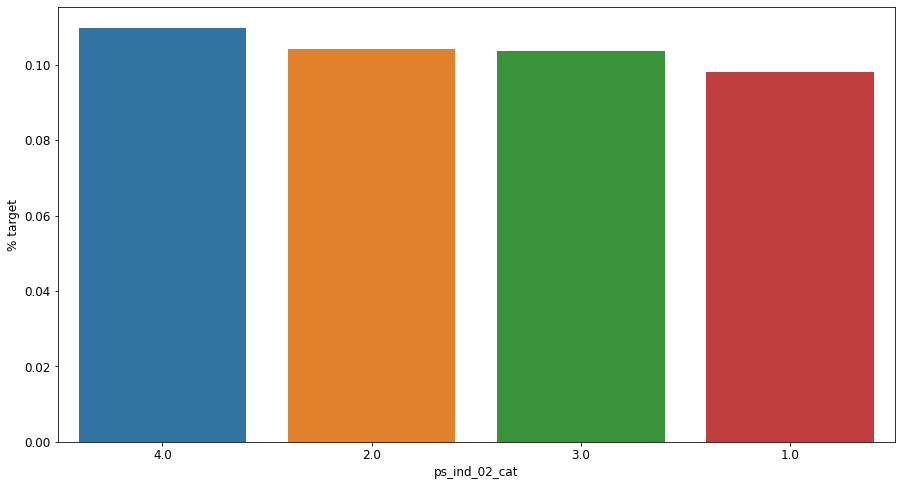

<Figure size 432x288 with 0 Axes>

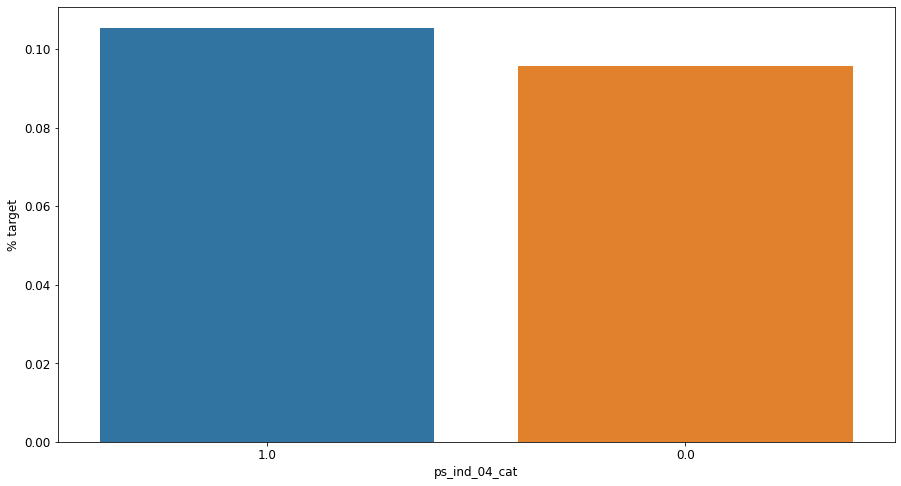

<Figure size 432x288 with 0 Axes>

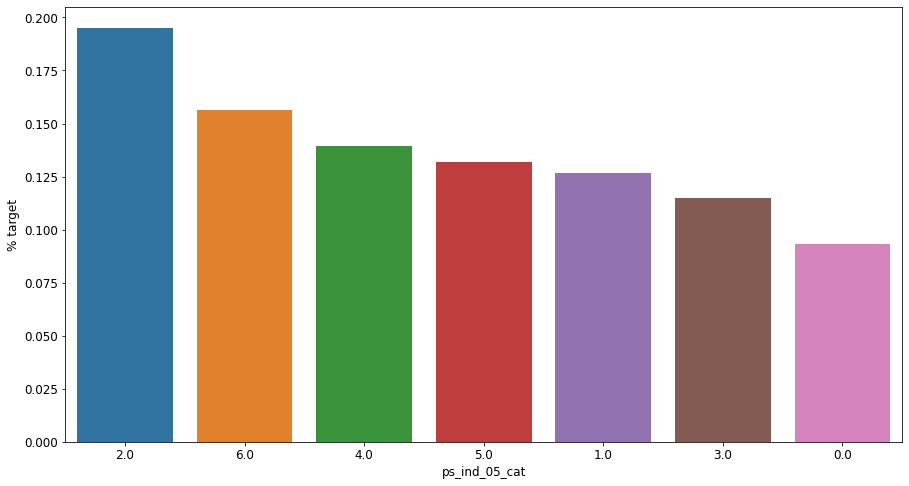

<Figure size 432x288 with 0 Axes>

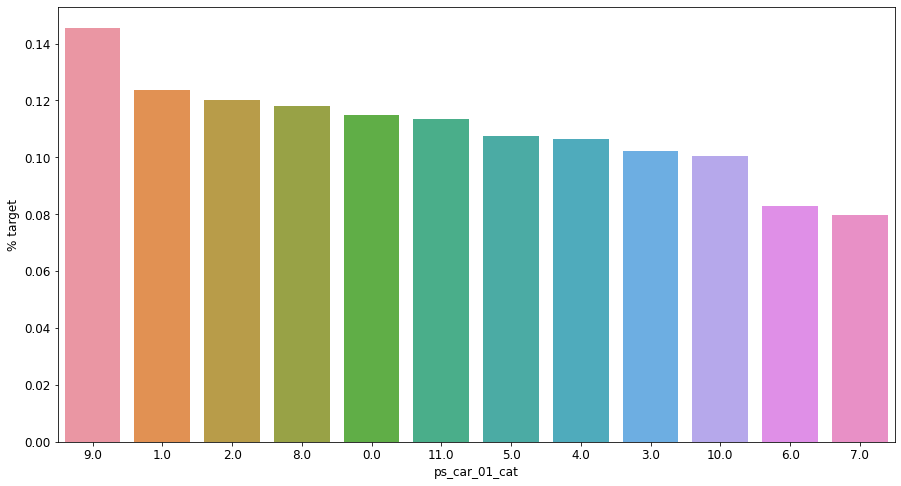

<Figure size 432x288 with 0 Axes>

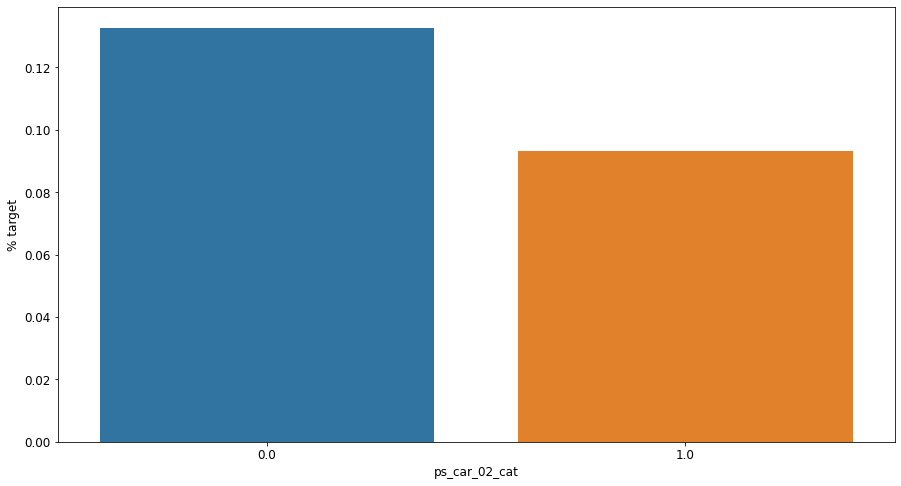

<Figure size 432x288 with 0 Axes>

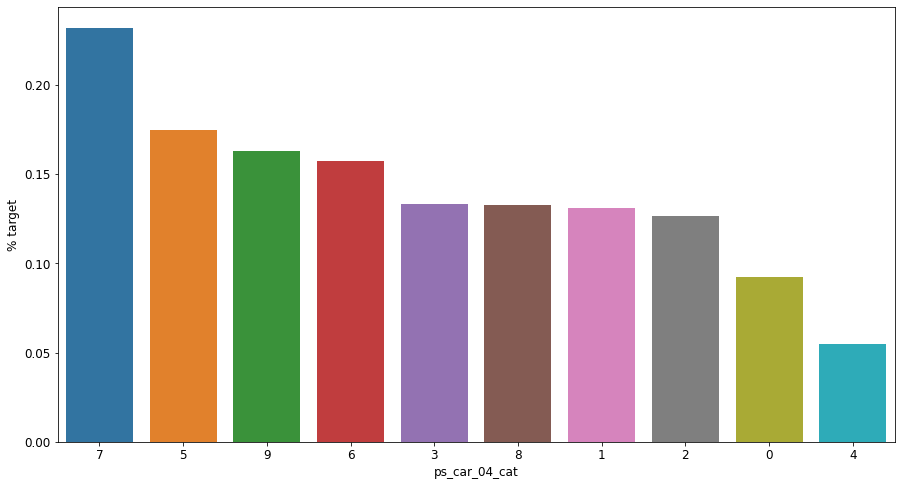

<Figure size 432x288 with 0 Axes>

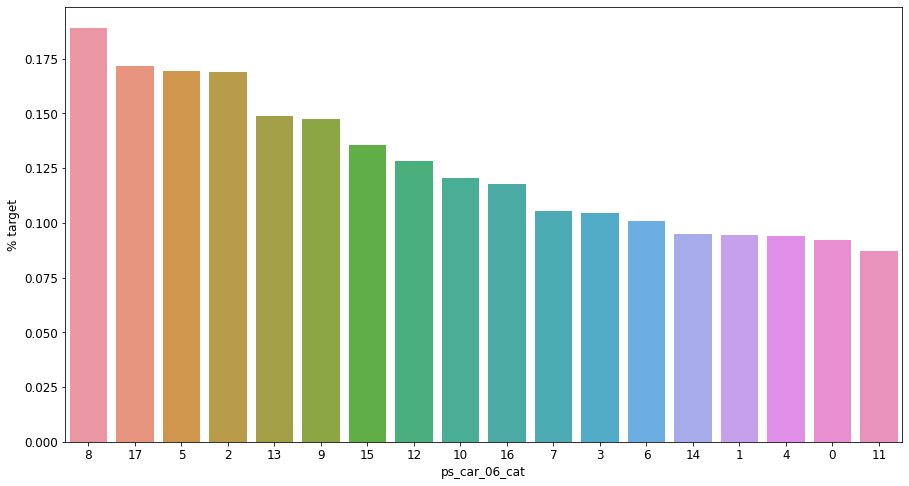

<Figure size 432x288 with 0 Axes>

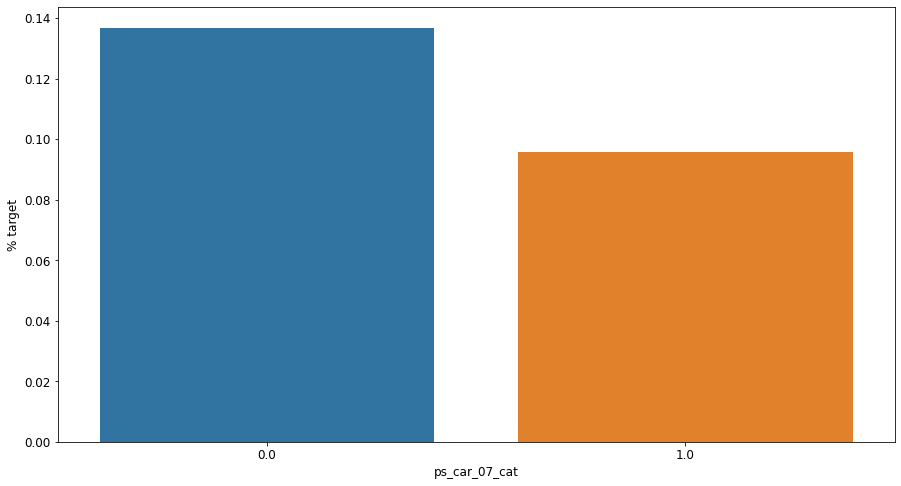

<Figure size 432x288 with 0 Axes>

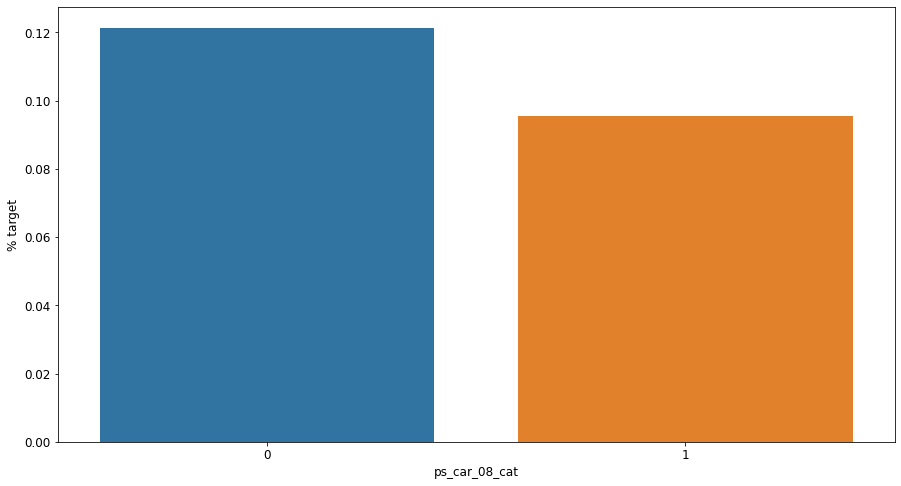

<Figure size 432x288 with 0 Axes>

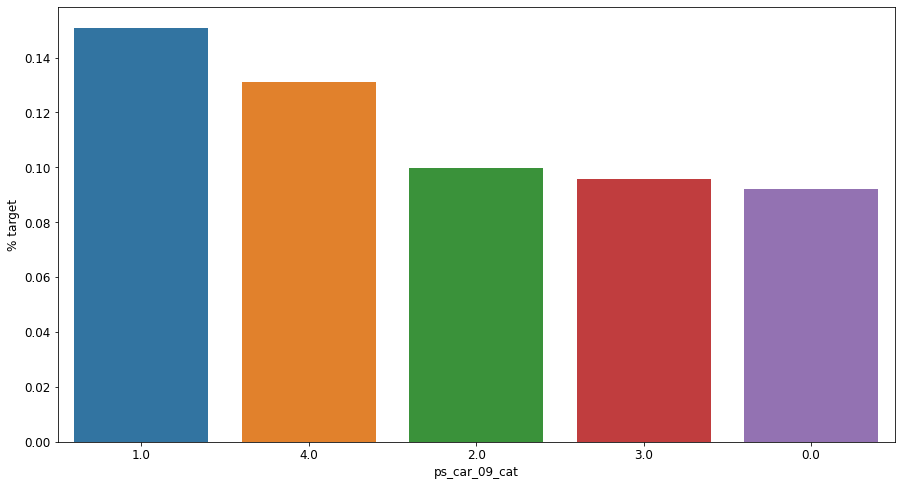

<Figure size 432x288 with 0 Axes>

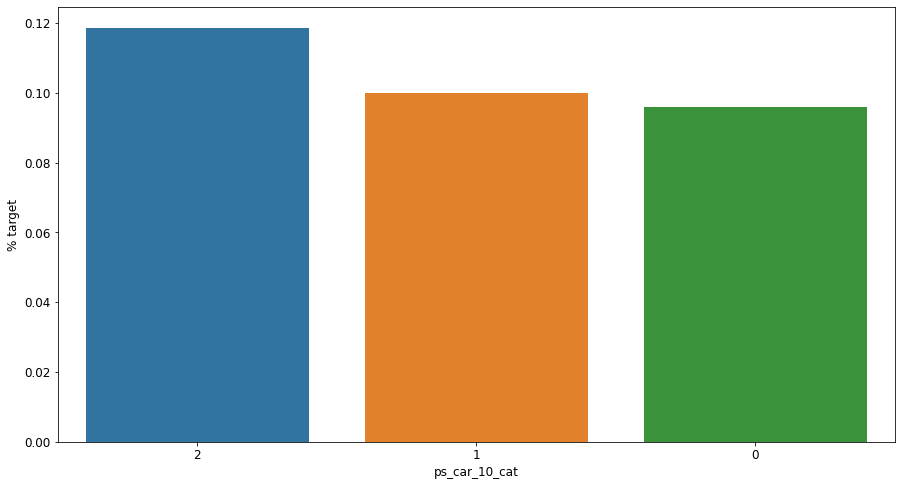

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(15,8))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=12)
    plt.xlabel(f, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

As we can see from the variables with missing values, it is a good idea to keep the missing values as a separate category value, instead of replacing them by the mode for instance. The customers with a missing value appear to have a much higher (in some cases much lower) probability to ask for an insurance claim.

Interval variables
Checking the correlations between interval variables. A heatmap is a good way to visualize the correlation between variables. The code below is based on an example by Michael Waskom

# Heatmap

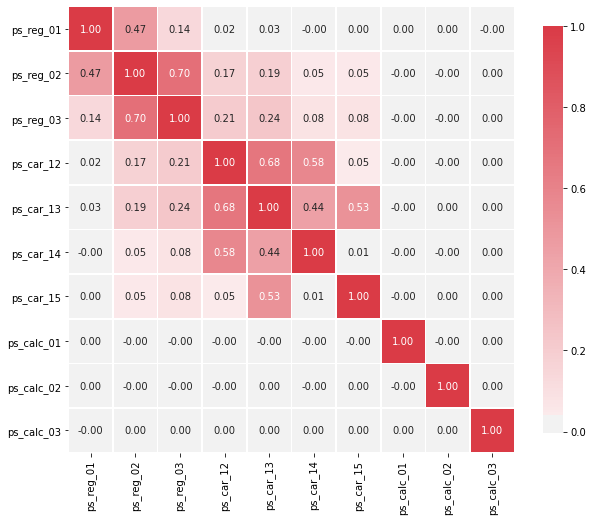

In [ ]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

There are a strong correlations between the variables:

ps_reg_02 and ps_reg_03 (0.7)

ps_car_12 and ps_car13 (0.67)

ps_car_12 and ps_car14 (0.58)

ps_car_13 and ps_car15 (0.67)

Seaborn has some handy plots to visualize the (linear) relationship between variables. We could use a pairplot to visualize the relationship between the variables. But because the heatmap already showed the limited number of correlated variables, we'll look at each of the highly correlated variables separately.

NOTE: I take a sample of the train data to speed up the process.

In [ ]:
s = train.sample(frac=0.1)

ps_reg_02 and ps_reg_03

As the regression line shows, there is a linear relationship between these variables. Thanks to the hue parameter we can see that the regression lines for target=0 and target=1 are the same.

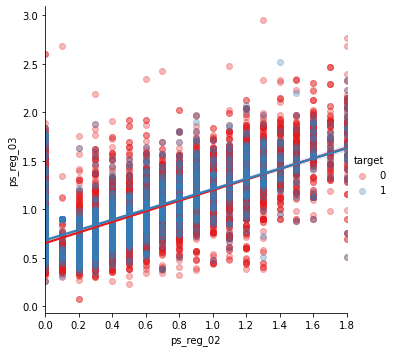

In [ ]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_12 and ps_car_13

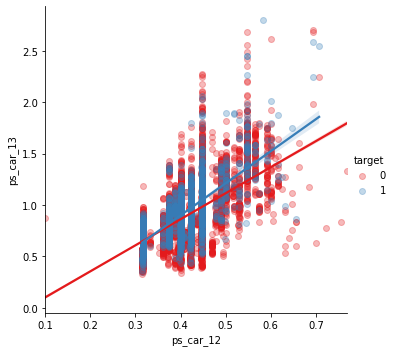

In [ ]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_12 and ps_car_14

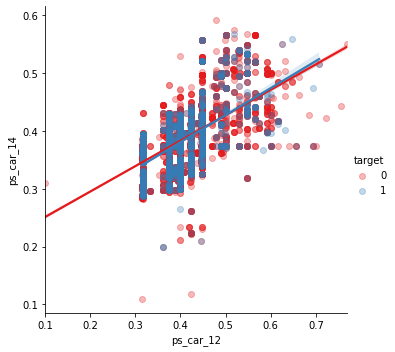

In [ ]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_13 and ps_car_15

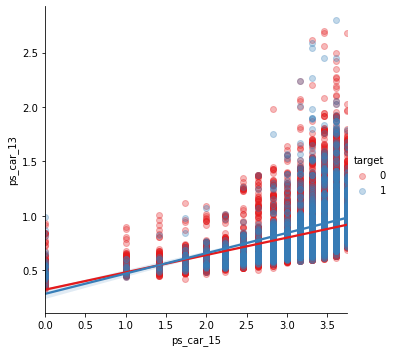

In [ ]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

Allright, so now what? How can we decide which of the correlated variables to keep? We could perform Principal Component Analysis (PCA) on the variables to reduce the dimensions. In the AllState Claims Severity Competition I made this kernel to do that. But as the number of correlated variables is rather low, we will let the model do the heavy-lifting.

Checking the correlations between ordinal variables

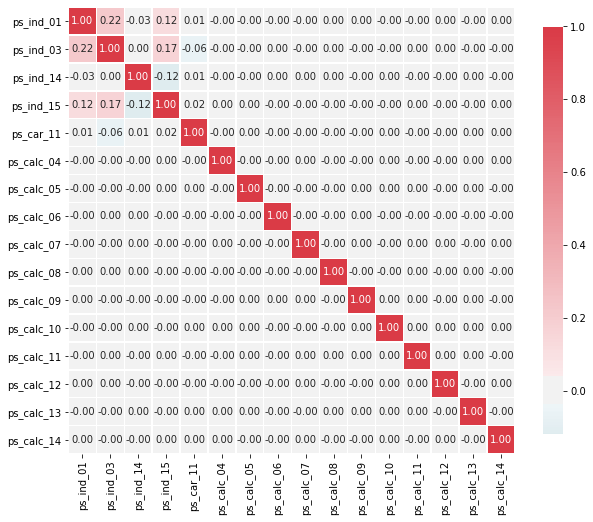

In [ ]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

For the ordinal variables we do not see many correlations. We could, on the other hand, look at how the distributions are when grouping by the target value.

# Feature engineering

Creating dummy variables

The values of the categorical variables do not represent any order or magnitude. For instance, category 2 is not twice the value of category 1. Therefore we can create dummy variables to deal with that. We drop the first dummy variable as this information can be derived from the other dummy variables generated for the categories of the original variable.

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 102 variables in train


So, creating dummy variables adds 52 variables to the training set.

Creating interaction variables

In [ ]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # Remove the original columns
# Concat the interaction variables to the train data
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 102 variables in train
After creating interactions we have 157 variables in train


In [ ]:
print(v)

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object', name='varname')


In [ ]:
train.head()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_11_cat_te,ps_ind_02_cat_2.0,ps_ind_02_cat_3.0,ps_ind_02_cat_4.0,ps_ind_04_cat_1.0,...,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,1303831,0,1,4,0,0,1,0,0,0,0,0,0,6,1,0,0,0.7,1.7,1.300240,3.0,0.446990,1.293116,0.454973,3.464102,0.0,0.6,0.7,3,2,9,2,9,1,9,7,3,2,9,0,1,0,0,0,0,0.121650,0,0,0,0,...,0.318481,2.424871,0.00,0.42,0.49,2.89,2.210409,0.759883,2.198297,0.773453,5.888973,0.00,1.02,1.19,1.690625,0.581194,1.681362,0.591574,4.504165,0.000000,0.780144,0.910168,0.1998,0.578010,0.203368,1.548419,0.000000,0.268194,0.312893,1.672149,0.588332,4.479485,0.000000,0.775870,0.905181,0.2070,1.576071,0.000000,0.272984,0.318481,12.0,0.000000,2.078461,2.424871,0.00,0.00,0.00,0.36,0.42,0.49
1,471100,0,2,6,0,1,0,0,0,0,0,0,0,3,1,0,0,0.8,0.1,0.725862,2.0,0.374166,0.815378,0.371618,3.605551,0.0,0.8,0.2,2,1,6,4,10,2,6,6,1,1,11,1,1,0,0,0,0,0.085176,1,0,0,1,...,0.297294,2.884441,0.00,0.64,0.16,0.01,0.072586,0.037417,0.081538,0.037162,0.360555,0.00,0.08,0.02,0.526875,0.271593,0.591851,0.269743,2.617131,0.000000,0.580689,0.145172,0.1400,0.305086,0.139047,1.349074,0.000000,0.299333,0.074833,0.664841,0.303009,2.939886,0.000000,0.652302,0.163076,0.1381,1.339888,0.000000,0.297294,0.074324,13.0,0.000000,2.884441,0.721110,0.00,0.00,0.00,0.64,0.16,0.04
2,619926,0,5,1,0,0,0,1,0,0,0,0,0,4,1,0,0,0.1,0.5,0.897504,3.0,0.374166,0.722956,0.393700,2.828427,0.1,0.1,0.9,4,2,7,2,10,2,7,6,0,3,7,0,1,1,0,1,0,0.101458,1,0,0,1,...,0.039370,0.282843,0.01,0.01,0.09,0.25,0.448752,0.187083,0.361478,0.196850,1.414214,0.05,0.05,0.45,0.805513,0.335815,0.648856,0.353348,2.538524,0.089750,0.089750,0.807753,0.1400,0.270505,0.147309,1.058301,0.037417,0.037417,0.336749,0.522665,0.284628,2.044828,0.072296,0.072296,0.650660,0.1550,1.113553,0.039370,0.039370,0.354330,8.0,0.282843,0.282843,2.545584,0.01,0.01,0.09,0.01,0.09,0.81
3,963922,0,3,5,0,0,1,0,0,0,0,0,0,10,0,0,0,0.6,0.6,0.871421,1.0,0.316228,0.640280,0.347275,3.316625,0.1,0.2,0.0,3,1,8,0,8,2,7,1,1,4,15,0,0,1,0,0,0,0.088122,0,0,0,0,...,0.208365,1.989975,0.06,0.12,0.00,0.36,0.522853,0.189737,0.384168,0.208365,1.989975,0.06,0.12,0.00,0.759375,0.275568,0.557954,0.302623,2.890177,0.087142,0.174284,0.000000,0.1000,0.202474,0.109818,1.048809,0.031623,0.063246,0.000000,0.409959,0.222353,2.123569,0.064028,0.128056,0.000000,0.1206,1.151781,0.034728,0.069455,0.000000,11.0,0.331662,0.663325,0.000000,0.01,0.02,0.00,0.04,0.00,0.00
4,1201104,0,1,8,1,0,0,0,0,0,0,0,0,12,1,0,0,0.3,0.3,0.897504,3.0,0.400000,0.758492,0.382623,2.645751,0.6,0.8,0.3,3,1,7,2,11,0,13,2,0,7,5,0,0,1,0,1,0,0.081150,0,0,0,0,...,0.114787,0.793725,0.18,0.2

This adds extra interaction variables to the train data. Thanks to the get_feature_names method we can assign column names to these new variables.

In [ ]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_11_cat_te
0,0,0,1.0,8,1.0,0.0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7.0,1.0,0,1,1.0,1,2.0,1,1.0,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1,0.085112
1,1,4,2.0,5,1.0,0.0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4.0,1.0,0,11,1.0,1,0.0,1,1.0,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1,0.074463
2,2,5,1.0,3,0.0,0.0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11.0,1.0,0,14,1.0,1,2.0,1,3.0,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0,0.099196
3,3,0,1.0,6,0.0,0.0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,0.894895,7.0,1.0,0,1,1.0,1,2.0,1,2.0,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0,0.095985
4,4,5,1.0,7,0.0,0.0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11.0,1.0,0,11,1.0,1,2.0,1,3.0,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1,0.101381


In [ ]:
v_test = meta_test[(meta_test['level_test'] == 'nominal') & (meta_test['keep_test'])]
v_test = v_test.drop(["ps_car_03_cat", "ps_car_05_cat", "ps_car_11_cat"], axis=0)
print('v_test before index: ', v_test)
v_test = v_test.index
print('v_test after index: ', v_test)
print('Before dummification we have {} variables in test'.format(test.shape[1]))
test = pd.get_dummies(test, columns=v_test, drop_first=True)
print('After dummification we have {} variables in test'.format(test.shape[1]))

v_test before index:                role_test level_test  keep_test  dtype keep
varname                                                  
ps_ind_02_cat     input    nominal       True    NaN  NaN
ps_ind_04_cat     input    nominal       True    NaN  NaN
ps_ind_05_cat     input    nominal       True    NaN  NaN
ps_car_01_cat     input    nominal       True    NaN  NaN
ps_car_02_cat     input    nominal       True    NaN  NaN
ps_car_04_cat     input    nominal       True    NaN  NaN
ps_car_06_cat     input    nominal       True    NaN  NaN
ps_car_07_cat     input    nominal       True    NaN  NaN
ps_car_08_cat     input    nominal       True    NaN  NaN
ps_car_09_cat     input    nominal       True    NaN  NaN
ps_car_10_cat     input    nominal       True    NaN  NaN
v_test after index:  Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_c

# Feature selection (no need)

Removing features with low or zero variance

Personally, I prefer to let the classifier algorithm chose which features to keep. But there is one thing that we can do ourselves. That is removing features with no or a very low variance. Sklearn has a handy method to do that: VarianceThreshold. By default it removes features with zero variance. This will not be applicable for this competition as we saw there are no zero-variance variables in the previous steps. But if we would remove features with less than 1% variance, we would remove 31 variables.

In [ ]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2.0', 'ps_ind_05_cat_5.0', 'ps_car_01_cat_1.0', 'ps_car_01_cat_2.0', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4.0', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


We would lose rather many variables if we would select based on variance. But because we do not have so many variables, we'll let the classifier chose. For data sets with many more variables this could reduce the processing time.

Sklearn also comes with other feature selection methods. One of these methods is SelectFromModel in which you let another classifier select the best features and continue with these. Below I'll show you how to do that with a Random Forest.



In [ ]:
selector_test = VarianceThreshold(threshold=.01)
selector_test.fit(test.drop(['id'], axis=1)) # Fit to test without id variable

f_test = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v_test = test.drop(['id'], axis=1).columns[f_test(selector_test.get_support())]
print('{} variables have too low variance.'.format(len(v_test)))
print('These variables are {}'.format(list(v_test)))

25 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2.0', 'ps_ind_05_cat_5.0', 'ps_car_01_cat_1.0', 'ps_car_01_cat_2.0', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4.0', 'ps_car_10_cat_1', 'ps_car_10_cat_2']


# Create X, y for sklearn and keras models

In [ ]:
train = train.set_index('id')

In [ ]:
X = train.drop(['target'], axis=1)
y = train['target']
print(X.shape)
X.head()

(216940, 155)


,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_11_cat_te,ps_ind_02_cat_2.0,ps_ind_02_cat_3.0,ps_ind_02_cat_4.0,ps_ind_04_cat_1.0,ps_ind_05_cat_1.0,ps_ind_05_cat_2.0,...,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1303831,1,4,0,0,1,0,0,0,0,0,0,6,1,0,0,0.7,1.7,1.300240,3.0,0.446990,1.293116,0.454973,3.464102,0.0,0.6,0.7,3,2,9,2,9,1,9,7,3,2,9,0,1,0,0,0,0,0.121650,0,0,0,0,0,0,...,0.318481,2.424871,0.00,0.42,0.49,2.89,2.210409,0.759883,2.198297,0.773453,5.888973,0.00,1.02,1.19,1.690625,0.581194,1.681362,0.591574,4.504165,0.000000,0.780144,0.910168,0.1998,0.578010,0.203368,1.548419,0.000000,0.268194,0.312893,1.672149,0.588332,4.479485,0.000000,0.775870,0.905181,0.2070,1.576071,0.000000,0.272984,0.318481,12.0,0.000000,2.078461,2.424871,0.00,0.00,0.00,0.36,0.42,0.49
471100,2,6,0,1,0,0,0,0,0,0,0,3,1,0,0,0.8,0.1,0.725862,2.0,0.374166,0.815378,0.371618,3.605551,0.0,0.8,0.2,2,1,6,4,10,2,6,6,1,1,11,1,1,0,0,0,0,0.085176,1,0,0,1,0,0,...,0.297294,2.884441,0.00,0.64,0.16,0.01,0.072586,0.037417,0.081538,0.037162,0.360555,0.00,0.08,0.02,0.526875,0.271593,0.591851,0.269743,2.617131,0.000000,0.580689,0.145172,0.1400,0.305086,0.139047,1.349074,0.000000,0.299333,0.074833,0.664841,0.303009,2.939886,0.000000,0.652302,0.163076,0.1381,1.339888,0.000000,0.297294,0.074324,13.0,0.000000,2.884441,0.721110,0.00,0.00,0.00,0.64,0.16,0.04
619926,5,1,0,0,0,1,0,0,0,0,0,4,1,0,0,0.1,0.5,0.897504,3.0,0.374166,0.722956,0.393700,2.828427,0.1,0.1,0.9,4,2,7,2,10,2,7,6,0,3,7,0,1,1,0,1,0,0.101458,1,0,0,1,0,0,...,0.039370,0.282843,0.01,0.01,0.09,0.25,0.448752,0.187083,0.361478,0.196850,1.414214,0.05,0.05,0.45,0.805513,0.335815,0.648856,0.353348,2.538524,0.089750,0.089750,0.807753,0.1400,0.270505,0.147309,1.058301,0.037417,0.037417,0.336749,0.522665,0.284628,2.044828,0.072296,0.072296,0.650660,0.1550,1.113553,0.039370,0.039370,0.354330,8.0,0.282843,0.282843,2.545584,0.01,0.01,0.09,0.01,0.09,0.81
963922,3,5,0,0,1,0,0,0,0,0,0,10,0,0,0,0.6,0.6,0.871421,1.0,0.316228,0.640280,0.347275,3.316625,0.1,0.2,0.0,3,1,8,0,8,2,7,1,1,4,15,0,0,1,0,0,0,0.088122,0,0,0,0,0,0,...,0.208365,1.989975,0.06,0.12,0.00,0.36,0.522853,0.189737,0.384168,0.208365,1.989975,0.06,0.12,0.00,0.759375,0.275568,0.557954,0.302623,2.890177,0.087142,0.174284,0.000000,0.1000,0.202474,0.109818,1.048809,0.031623,0.063246,0.000000,0.409959,0.222353,2.123569,0.064028,0.128056,0.000000,0.1206,1.151781,0.034728,0.069455,0.000000,11.0,0.331662,0.663325,0.000000,0.01,0.02,0.00,0.04,0.00,0.00
1201104,1,8,1,0,0,0,0,0,0,0,0,12,1,0,0,0.3,0.3,0.897504,3.0,0.400

In [ ]:
y.head()

id
1303831    0
471100     0
619926     0
963922     0
1201104    0
Name: target, dtype: int64

# Convert train / test file into H2O frames

In [ ]:
hf_train_file = h2o.H2OFrame(train)
hf_test_file = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1612)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, shuffle=True, random_state=1612)
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_val:', y_val.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (173552, 155)
Shape of y_train: (173552,)
Shape of X_val: (21694, 155)
Shape of y_val: (21694,)
Shape of X_test: (21694, 155)
Shape of y_test: (21694,)


## Pairplot

In [ ]:
# Other Data Preparation & Exploration: https://www.kaggle.com/bertcarremans/data-preparation-exploration
# import seaborn as sns
# sns.set()
# sns.pairplot(train, hue='target')

# Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# B. Ensemble Classifiers, XGBoost Classifier, Deep Neural Network

## B.1. Single Decision Tree

### B.1.1 Confusion Matrix

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameters of Best Decision Tree:  {'min_samples_leaf': 5, 'max_depth': 2, 'criterion': 'gini'}
Decision Tree classifier performance:
Balanced accuracy: 0.50 - Geometric mean 0.00
[[19524     0]
 [ 2170     0]]



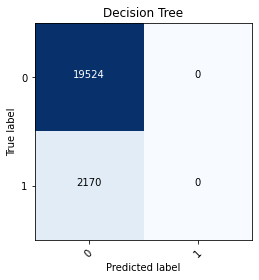

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets  
params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}

decision_tree = DecisionTreeClassifier(random_state=1612)
decision_tree.fit(X_train, y_train)

rs_decision_tree = RandomizedSearchCV(decision_tree, params, cv=5)
rs_decision_tree.fit(X_train, y_train)
best_decision_tree = rs_decision_tree.fit(X_train, y_train)
print('Best parameters of Best Decision Tree: ', best_decision_tree.best_params_)
y_pred_best_decision_tree = rs_decision_tree.predict(X_test)
print('Decision Tree classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_decision_tree),
              geometric_mean_score(y_test, y_pred_best_decision_tree)))
cm_decision_tree = confusion_matrix(y_test, y_pred_best_decision_tree)
fig, ax = plt.subplots()
plot_confusion_matrix(cm_decision_tree, classes=np.unique(y), ax=ax,
                      title='Decision Tree')

### B.1.2 Mean ROC AUC

In [ ]:
# Single decision tree
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model
train_scores_decision_tree = cross_val_score(best_decision_tree, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_decision_tree = cross_val_score(best_decision_tree, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_decision_tree))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_decision_tree))

KeyboardInterrupt: ignored

### B.1.3 Classification report

In [ ]:
y_pred_best_decision_tree_train = best_decision_tree.predict(X_train)
print('Accuracy score on Train Set of Best Decision Tree: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_decision_tree_train)))
print('Accuracy score on Test Set of Best Decision Tree: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_decision_tree)))
decision_tree_precision_train = precision_score(y_train, y_pred_best_decision_tree_train)
print('Precision score on Train Set of Best decision_tree: %f' % decision_tree_precision_train)
decision_tree_precision = precision_score(y_test, y_pred_best_decision_tree)
print('Precision score on Test Set of Best decision_tree: %f' % decision_tree_precision)
decision_tree_recall_train = recall_score(y_train, y_pred_best_decision_tree_train)
print('Recall score on Train Set of Best Decision Tree: %f' % decision_tree_recall_train)
decision_tree_recall = recall_score(y_test, y_pred_best_decision_tree)
print('Recall score on Test Set of Best Decision Tree: %f' % decision_tree_recall)
decision_tree_f1_train = f1_score(y_train, y_pred_best_decision_tree_train)
print('F1-score on Train Set of Best Decision Tree: %f' % decision_tree_f1_train)
decision_tree_f1 = f1_score(y_test, y_pred_best_decision_tree)
print('F1-score on Test Set of Best Decision Tree: %f' % decision_tree_f1)
print('\n')
print('Classification report on Train Set of Best Decision Tree: ', '\n', classification_report(y_train, y_pred_best_decision_tree_train))
print('\n')
print('Classification report on Test Set of Best Decision Tree: ', '\n', classification_report(y_test, y_pred_best_decision_tree))

Accuracy score on Train Set of Best Decision Tree: 0.90047
Accuracy score on Test Set of Best Decision Tree: 0.89997
Precision score on Train Set of Best decision_tree: 0.000000
Precision score on Test Set of Best decision_tree: 0.000000
Recall score on Train Set of Best Decision Tree: 0.000000
Recall score on Test Set of Best Decision Tree: 0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1-score on Train Set of Best Decision Tree: 0.000000
F1-score on Test Set of Best Decision Tree: 0.000000




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report on Train Set of Best Decision Tree:  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95    156279
           1       0.00      0.00      0.00     17273

    accuracy                           0.90    173552
   macro avg       0.45      0.50      0.47    173552
weighted avg       0.81      0.90      0.85    173552



Classification report on Test Set of Best Decision Tree:  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     19524
           1       0.00      0.00      0.00      2170

    accuracy                           0.90     21694
   macro avg       0.45      0.50      0.47     21694
weighted avg       0.81      0.90      0.85     21694



In [ ]:
# # import joblib
# model_decision_tree = "/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro's Safer Driver Prediction/model_decision_tree.sav"
# joblib.dump(best_decision_tree, model_decision_tree)

## B.2. Bagging classifier with and without sampling

### B.2.1 Confusion Matrix

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Best params of Bagging:  {'warm_start': False, 'verbose': 0, 'oob_score': False, 'n_estimators': 10, 'max_features': 1, 'bootstrap_features': True, 'bootstrap': True}
Best params of Balanced Bagging:  {'warm_start': False, 'verbose': 1, 'oob_score': False, 'n_estimators': 10, 'max_features': 2, 'bootstrap_features': False, 'bootstrap': True}
y_pred_best_bagging:  [0 0 0 ... 0 0 0]
y_pred_best_balanced_bagging:  [0 0 1 ... 0 0 1]
Bagging classifier performance:
Balanced accuracy: 0.50 - Geometric mean 0.00
[[19524     0]
 [ 2170     0]]

Balanced Bagging classifier performance:
Balanced accuracy: 0.52 - Geometric mean 0.50
[[13043  6481]
 [ 1353   817]]



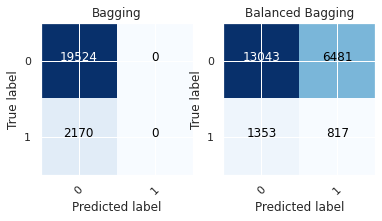

In [ ]:
params = {
    'n_estimators': [5, 10],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'oob_score': [True, False],
    'warm_start': [True, False],
    'verbose': [0, 1],
    'max_features': [1,2],
}
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
# rs_bagging = dict(params) # no need
bagging = BaggingClassifier(random_state=1612)
rs_bagging = RandomizedSearchCV(bagging, params, n_jobs=-1, cv=5, scoring='accuracy',error_score=0)
best_bagging = rs_bagging.fit(X_train, y_train)

# rs_balanced_bagging = dict(params) # no need
balanced_bagging = BalancedBaggingClassifier(random_state=1612)
rs_balanced_bagging = RandomizedSearchCV(balanced_bagging, params, n_jobs=-1, cv=5, scoring='accuracy', error_score=0)
best_balanced_bagging = rs_balanced_bagging.fit(X_train, y_train)

print('Best params of Bagging: ', best_bagging.best_params_)
print('Best params of Balanced Bagging: ', best_balanced_bagging.best_params_)

y_pred_best_bagging = best_bagging.predict(X_test)
y_pred_best_balanced_bagging = best_balanced_bagging.predict(X_test)
print('y_pred_best_bagging: ', y_pred_best_bagging)
print('y_pred_best_balanced_bagging: ', y_pred_best_balanced_bagging)

# Balancing each bootstrap sample allows to increase significantly the balanced accuracy and the geometric mean.
print('Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_bagging),
              geometric_mean_score(y_test, y_pred_best_bagging)))
cm_best_bagging = confusion_matrix(y_test, y_pred_best_bagging)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_best_bagging, classes=np.unique(y), ax=ax[0],
                      title='Bagging')

print('Balanced Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_balanced_bagging),
              geometric_mean_score(y_test, y_pred_best_balanced_bagging)))
cm_best_balanced_bagging = confusion_matrix(y_test, y_pred_best_balanced_bagging)
plot_confusion_matrix(cm_best_balanced_bagging, classes=np.unique(y),
                      ax=ax[1], title='Balanced Bagging')

### B.2.2 Mean ROC AUC 

In [ ]:
# Best Bagging classifier
# Define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)

# Evaluate model
train_scores_best_bagging = cross_val_score(best_bagging, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_bagging = cross_val_score(best_bagging, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# Summarize performance
print('Mean ROC AUC on Train Set of Best Bagging: %.3f' % mean(train_scores_best_bagging))
print('Mean ROC AUC on Test Set of Best Bagging: %.3f' % mean(test_scores_best_bagging))

In [ ]:
# Best Balanced Bagging classifier 
# Define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)

# Evaluate model
train_scores_best_balanced_bagging = cross_val_score(best_balanced_bagging, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_balanced_bagging = cross_val_score(best_balanced_bagging, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# Summarize performance
print('Mean ROC AUC on Train Set of Best Balanced Bagging: %.3f' % mean(train_scores_best_balanced_bagging))
print('Mean ROC AUC on Test Set of Best Balanced Bagging: %.3f' % mean(test_scores_best_balanced_bagging))

### B.2.3 Classification report

In [ ]:
y_pred_best_bagging_train = best_bagging.predict(X_train)
print('Accuracy score on Train Set of Best Bagging: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_bagging_train)))
print('Accuracy score on Test Set of Best Bagging: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_bagging)))
bagging_precision_train = precision_score(y_train, y_pred_best_bagging_train)
print('Precision score on Train Set of Best Bagging: %f' % bagging_precision_train)
bagging_precision = precision_score(y_test, y_pred_best_bagging)
print('Precision score on Test Set of Best Bagging: %f' % bagging_precision)
bagging_recall_train = recall_score(y_train, y_pred_best_bagging_train)
print('Recall score on Train Set of Best Bagging: %f' % bagging_recall_train)
bagging_recall = recall_score(y_test, y_pred_best_bagging)
print('Recall on Test Set of Best Bagging: %f' % bagging_recall)
bagging_f1 = f1_score(y_test, y_pred_best_bagging)
print('F1-score on Test Set of Best Bagging: %f' % bagging_f1)
print('\n')
print('Classification report on Train Set of Best Bagging: ', '\n', classification_report(y_train, y_pred_best_bagging_train))
print('Classification report on Test Set of Best Bagging: ', '\n', classification_report(y_test, y_pred_best_bagging))

Accuracy score on Train Set of Best Bagging: 0.90047
Accuracy score on Test Set of Best Bagging: 0.89997
Precision score on Train Set of Best Bagging: 0.000000
Precision score on Test Set of Best Bagging: 0.000000
Recall score on Train Set of Best Bagging: 0.000000
Recall on Test Set of Best Bagging: 0.000000
F1-score on Test Set of Best Bagging: 0.000000




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report on Train Set of Best Bagging:  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95    156279
           1       0.00      0.00      0.00     17273

    accuracy                           0.90    173552
   macro avg       0.45      0.50      0.47    173552
weighted avg       0.81      0.90      0.85    173552

Classification report on Test Set of Best Bagging:  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     19524
           1       0.00      0.00      0.00      2170

    accuracy                           0.90     21694
   macro avg       0.45      0.50      0.47     21694
weighted avg       0.81      0.90      0.85     21694



In [ ]:
y_pred_best_balanced_bagging_train = best_bagging.predict(X_train)
print('Accuracy score on Train Set of Best Balanced Bagging: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_balanced_bagging_train)))
print('Accuracy score on Test Set of Best Balanced Bagging: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_balanced_bagging)))
balanced_bagging_precision_train = precision_score(y_train, y_pred_best_balanced_bagging_train)
print('Precision score on Train Set of Best Balanced Bagging: %f' % balanced_bagging_precision_train)
balanced_bagging_precision = precision_score(y_test, y_pred_best_balanced_bagging)
print('Precision score on Test Set of Best Balanced Bagging: %f' % balanced_bagging_precision)
balanced_bagging_recall_train = recall_score(y_train, y_pred_best_balanced_bagging_train)
print('Recall score on Train Set of Best Balanced Bagging: %f' % balanced_bagging_recall_train)
balanced_bagging_recall = recall_score(y_test, y_pred_best_balanced_bagging)
print('Recall score on Test Set of Best Balanced Bagging: %f' % balanced_bagging_recall)
balanced_bagging_f1_train = f1_score(y_train, y_pred_best_balanced_bagging_train)
print('F1-score on Train Set of Best Balanced Bagging: %f' % balanced_bagging_f1_train)
balanced_bagging_f1 = f1_score(y_test, y_pred_best_balanced_bagging)
print('F1-score on Test Set of Best Balanced Bagging: %f' % balanced_bagging_f1)
print('\n')
print('Classification report on Train Set of Best Balanced Bagging: ', '\n', classification_report(y_train, y_pred_best_balanced_bagging_train))
print('\n')
print('Classification report on Test Set of Best Balanced Bagging: ', '\n', classification_report(y_test, y_pred_best_balanced_bagging))

Accuracy score on Train Set of Best Balanced Bagging: 0.90047
Accuracy score on Test Set of Best Balanced Bagging: 0.63889
Precision score on Train Set of Best Balanced Bagging: 0.000000
Precision score on Test Set of Best Balanced Bagging: 0.111948
Recall score on Train Set of Best Balanced Bagging: 0.000000
Recall score on Test Set of Best Balanced Bagging: 0.376498


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1-score on Train Set of Best Balanced Bagging: 0.000000
F1-score on Test Set of Best Balanced Bagging: 0.172581




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report on Train Set of Best Balanced Bagging:  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95    156279
           1       0.00      0.00      0.00     17273

    accuracy                           0.90    173552
   macro avg       0.45      0.50      0.47    173552
weighted avg       0.81      0.90      0.85    173552



Classification report on Test Set of Best Balanced Bagging:  
               precision    recall  f1-score   support

           0       0.91      0.67      0.77     19524
           1       0.11      0.38      0.17      2170

    accuracy                           0.64     21694
   macro avg       0.51      0.52      0.47     21694
weighted avg       0.83      0.64      0.71     21694



In [ ]:
# # import joblib
# model_best_bagging = "/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro's Safer Driver Prediction/model_best_bagging.sav"
# joblib.dump(best_bagging, model_best_bagging)
# model_best_balanced_bagging = "/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro's Safer Driver Prediction/model_best_balanced_bagging.sav"
# joblib.dump(best_balanced_bagging, model_best_balanced_bagging)

## B.3. Random Forest classifier with and without sampling


#### B.3.1 Confusion Matrix

Best params of Random Forest:  {'n_estimators': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 1, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}
Best params of Balanced Random Forest:  {'n_estimators': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 1, 'max_depth': 2, 'criterion': 'entropy', 'bootstrap': True}
y_pred_best_rf:  [0 0 0 ... 0 0 0]
y_pred_best_brf:  [0 0 0 ... 0 0 0]
Random Forest classifier performance:
Balanced accuracy: 0.50 - Geometric mean 0.00
[[19524     0]
 [ 2170     0]]

Balanced Random Forest classifier performance:
Balanced accuracy: 0.55 - Geometric mean 0.54
[[12624  6900]
 [ 1182   988]]



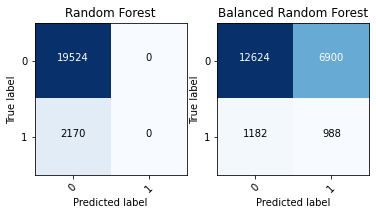

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {"max_depth": [2,3, None],
          "n_estimators": [5, 10],
          "max_features": [1, 3],
          "min_samples_split": [2, 3],
          "min_samples_leaf": [1, 3],
          "bootstrap": [True, False],
          "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier(random_state=1612, n_jobs=-1)
brf = BalancedRandomForestClassifier(random_state=1612, n_jobs=-1)

rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

rs_rf = RandomizedSearchCV(rf, params, cv=5)
best_rf = rs_rf.fit(X_train, y_train)
print('Best params of Random Forest: ', best_rf.best_params_)

rs_brf = RandomizedSearchCV(brf, params, cv=5)
best_brf = rs_brf.fit(X_train, y_train)
print('Best params of Balanced Random Forest: ', best_brf.best_params_)

y_pred_best_rf = best_rf.predict(X_test)
y_pred_best_brf = best_brf.predict(X_test)
print('y_pred_best_rf: ', y_pred_best_rf)
print('y_pred_best_brf: ', y_pred_best_brf)

# Similarly to the previous experiment, the balanced classifier outperform the
# classifier which learn from imbalanced bootstrap samples. In addition, random
# forest outsperforms the bagging classifier.
print('Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_rf),
              geometric_mean_score(y_test, y_pred_best_rf)))
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
fig, ax = plt.subplots(ncols=2) # 1 
plot_confusion_matrix(cm_best_rf, classes=np.unique(y), ax=ax[0],
                      title='Random Forest') # ax=ax

print('Balanced Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_brf),
              geometric_mean_score(y_test, y_pred_best_brf)))
cm_best_brf = confusion_matrix(y_test, y_pred_best_brf)
plot_confusion_matrix(cm_best_brf, classes=np.unique(y), ax=ax[1],
                      title='Balanced Random Forest')

### B.3.2 Mean ROC AUC

In [ ]:
# Random Forest classifier
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model
train_scores_best_rf = cross_val_score(best_rf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_rf = cross_val_score(best_rf, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set of Random Forest: %.3f' % mean(train_scores_best_rf))
print('Mean ROC AUC on Test Set of Random Forest: %.3f' % mean(test_scores_best_rf))

In [ ]:
# Balanced Random Forest classifier
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model
train_scores_best_brf = cross_val_score(best_brf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_brf = cross_val_score(best_brf, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set of Balanced Random Forest: %.3f' % mean(train_scores_best_brf))
print('Mean ROC AUC on Test Set of Balanced Random Forest: %.3f' % mean(test_scores_best_brf))

### B.3.4 Classification report

In [ ]:
y_pred_best_rf_train = best_rf.predict(X_train)
print('Accuracy score on Train Set of Best Random Forest: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_rf_train)))
print('Accuracy score on Test Set of Best Random Forest: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_rf)))
rf_precision_train = precision_score(y_train, y_pred_best_rf_train)
print('Precision score on Train Set of Best Random Forest: %f' % rf_precision_train)
rf_precision = precision_score(y_test, y_pred_best_rf)
print('Precision score on Test Set of Best Random Forest: %f' % rf_precision)
rf_recall_train = recall_score(y_train, y_pred_best_rf_train)
print('Recall score on Train Set of Best Random Forest: %f' % rf_recall_train)
rf_recall = recall_score(y_test, y_pred_best_rf)
print('Recall score on Test Set of Best Random Forest: %f' % rf_recall)
rf_f1_train = f1_score(y_train, y_pred_best_rf_train)
print('F1-score on Train Set of Best Random Forest: %f' % rf_f1_train)
rf_f1 = f1_score(y_test, y_pred_best_rf)
print('F1-score on Test Set of Best Random Forest: %f' % rf_f1)
print('\n')
print('Classification report on Train Set of Best Random Forest: ', '\n', classification_report(y_train, y_pred_best_rf_train))
print('\n')
print('Classification report on Test Set of Best Random Forest: ', '\n', classification_report(y_test, y_pred_best_rf))

Accuracy score on Train Set of Best Random Forest: 0.90047
Accuracy score on Test Set of Best Random Forest: 0.89997
Precision score on Train Set of Best Random Forest: 0.000000
Precision score on Test Set of Best Random Forest: 0.000000
Recall score on Train Set of Best Random Forest: 0.000000
Recall score on Test Set of Best Random Forest: 0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1-score on Train Set of Best Random Forest: 0.000000
F1-score on Test Set of Best Random Forest: 0.000000




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report on Train Set of Best Random Forest:  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95    156279
           1       0.00      0.00      0.00     17273

    accuracy                           0.90    173552
   macro avg       0.45      0.50      0.47    173552
weighted avg       0.81      0.90      0.85    173552



Classification report on Test Set of Best Random Forest:  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     19524
           1       0.00      0.00      0.00      2170

    accuracy                           0.90     21694
   macro avg       0.45      0.50      0.47     21694
weighted avg       0.81      0.90      0.85     21694



In [ ]:
y_pred_best_brf_train = best_brf.predict(X_train)
print('Accuracy score on Train Set of Best Balanced Random Forest: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_brf_train)))
print('Accuracy score on Test Set of Best Balanced Random Forest: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_brf)))
brf_precision_train = precision_score(y_train, y_pred_best_brf_train)
print('Precision score on Train Set of Best Random Forest: %f' % brf_precision_train)
brf_precision = precision_score(y_test, y_pred_best_brf)
print('Precision score on Test Set of Best Random Forest: %f' % brf_precision)
brf_recall_train = recall_score(y_train, y_pred_best_brf_train)
print('Recall score on Train Set of Best Random Forest: %f' % brf_recall_train)
brf_recall = recall_score(y_test, y_pred_best_brf)
print('Recall score on Test Set of Best Random Forest: %f' % brf_recall)
brf_f1_train = f1_score(y_train, y_pred_best_brf_train)
print('F1-score on Train Set of Best Random Forest: %f' % brf_f1_train)
brf_f1 = f1_score(y_test, y_pred_best_brf)
print('F1-score on Test Set of Best Random Forest: %f' % brf_f1)
print('\n')
print('Classification report on Train Set of Best Balanced Random Forest: ', '\n', classification_report(y_train, y_pred_best_brf_train))
print('\n')
print('Classification report on Test Set of Best Balanced Random Forest: ', '\n', classification_report(y_test, y_pred_best_brf))

Accuracy score on Train Set of Best Balanced Random Forest: 0.59348
Accuracy score on Test Set of Best Balanced Random Forest: 0.59583
Precision score on Train Set of Best Random Forest: 0.126065
Precision score on Test Set of Best Random Forest: 0.124687
Recall score on Train Set of Best Random Forest: 0.519944
Recall score on Test Set of Best Random Forest: 0.505069
F1-score on Train Set of Best Random Forest: 0.202928
F1-score on Test Set of Best Random Forest: 0.200000


Classification report on Train Set of Best Balanced Random Forest:  
               precision    recall  f1-score   support

           0       0.92      0.60      0.73    156279
           1       0.13      0.52      0.20     17273

    accuracy                           0.59    173552
   macro avg       0.52      0.56      0.47    173552
weighted avg       0.84      0.59      0.67    173552



Classification report on Test Set of Best Balanced Random Forest:  
               precision    recall  f1-score   suppor

In [ ]:
# # import joblib
# model_best_rf = "/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro's Safer Driver Prediction/model_best_rf.sav"
# joblib.dump(best_rf, model_best_rf)
# model_best_brf = "/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro's Safer Driver Prediction/model_best_brf.sav"
# joblib.dump(best_brf, model_best_brf)

## B.4. Boosting classifier (Easy Ensemble, RUS Boost, XGBoost)

#### B.4.1 Confusion Matrix

In [ ]:
# EEC: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.EasyEnsembleClassifier.html
from sklearn.model_selection import RandomizedSearchCV # "sampling_strategy": ['float', 'str', 'auto']
params_eec = {"warm_start": [True, False],
          "n_estimators": [5, 10],
          "sampling_strategy": ['float', 'auto'],
          "replacement": [True, False],
          "n_jobs": [1, -1],
          "verbose": [0, 1]}
base_estimator = AdaBoostClassifier()
eec = EasyEnsembleClassifier(random_state=1612, base_estimator=base_estimator)
rs_eec = RandomizedSearchCV(eec, params_eec, cv=5)
rs_eec.fit(X_train, y_train)
best_eec = rs_eec.fit(X_train, y_train)
print('Best params of Easy Ensemble: ', best_eec.best_params_)
y_pred_best_eec = best_eec.predict(X_test)
print('y_pred_best_eec: ', y_pred_best_eec)
print('Easy ensemble classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_eec),
              geometric_mean_score(y_test, y_pred_best_eec)))
cm_eec = confusion_matrix(y_test, y_pred_best_eec)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_eec, classes=np.unique(y), ax=ax,
                      title='Easy Ensemble classifier')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   46.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   46.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   45.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   45.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Don

KeyboardInterrupt: ignored

In [ ]:
# RUS Boost: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.RUSBoostClassifier.html
from sklearn.model_selection import RandomizedSearchCV
params_rusboost = {"n_estimators": [5, 10],
          "algorithm": ['SAMME', 'SAMME.R'],
          "sampling_strategy": ['float', 'auto'],
          "replacement": [True, False]}
base_estimator = AdaBoostClassifier()          
rusboost = RUSBoostClassifier(random_state=1612, base_estimator=base_estimator)
rs_rusboost = RandomizedSearchCV(rusboost, params_rusboost, cv=5)
rs_rusboost.fit(X_train, y_train)
best_rusboost = rs_rusboost.fit(X_train, y_train)
print('Best params of RUS Boost: ', best_rusboost.best_params_)
y_pred_best_rusboost = best_rusboost.predict(X_test)
print('y_pred_best_rusboost: ', y_pred_best_rusboost)
print('RUS Boost classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_rusboost),
              geometric_mean_score(y_test, y_pred_best_rusboost)))
cm_rusboost = confusion_matrix(y_test, y_pred_best_rusboost)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_rusboost, classes=np.unique(y), ax=ax,
                      title='RUS Boost classifier')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: When 'sampling_strategy' is a string, it needs to be one of {'minority': <function _sampling_strategy_minority at 0x7fb20ecc82f0>, 'majority': <function _sampling_strategy_majority at 0x7fb20ecc8158>, 'not minority': <function _sampling_strategy_not_minority at 0x7fb20ecc8268>, 'not majority': <function _sampling_strategy_not_majority at 0x7fb20ecc81e0>, 'all': <function _sampling_strategy_all at 0x7fb20ecc80d0>, 'auto': <function _sampling_strategy_auto at 0x7fb20ecc8378>}. Got 'float' instead.

  score_time = 0.0
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: When 'sampling_strategy' is a

Best params of XGBoost:  {'subsample': 0.6, 'n_estimators': 10, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.6}
y_pred_best_xgboost:  [0 0 0 ... 0 0 0]
best_xgboost Classifier performance:
Balanced accuracy: 0.50 - Geometric mean 0.00
[[19524     0]
 [ 2170     0]]



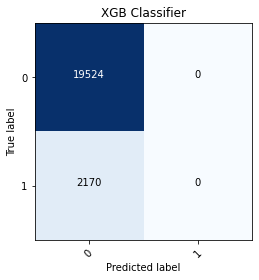

In [ ]:
# https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost       
# https://www.kaggle.com/saxinou/imbalanced-data-xgboost-tunning
from sklearn.model_selection import RandomizedSearchCV

params = {
        'min_child_weight': [1, 5],
        'n_estimators': [5, 10], 
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 4],
        'learning_rate': [0.01, 0.05]
        }

XGB = XGBClassifier(random_state=1612) # random_state=1612, n_jobs=-1
rs_xgboost = RandomizedSearchCV(XGB, params, cv=5)
rs_xgboost.fit(X_train, y_train)
best_xgboost = rs_xgboost.fit(X_train, y_train)
print('Best params of XGBoost: ', best_xgboost.best_params_)

y_pred_best_xgboost = best_xgboost.predict(X_test)
print('y_pred_best_xgboost: ', y_pred_best_xgboost)

# Similarly to the previous experiment, the balanced classifier outperform the
# classifier which learn from imbalanced bootstrap samples. In addition, random
# forest outsperforms the bagging classifier.

print('best_xgboost Classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_best_xgboost),
              geometric_mean_score(y_test, y_pred_best_xgboost)))
cm_best_xgboost = confusion_matrix(y_test, y_pred_best_xgboost)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_best_xgboost, classes=np.unique(y), ax=ax,
                      title='XGB Classifier')

### B.4.2 Mean ROC AUC 

In [ ]:
# Easy Ensemble for imbalanced classification
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model eec
train_scores_best_eec = cross_val_score(best_eec, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_eec = cross_val_score(best_eec, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC on Train Set of Easy Ensemble: %.3f' % mean(train_scores_best_eec))
print('Mean ROC AUC on Test Set of Easy Ensemble: %.3f' % mean(test_scores_best_eec))

In [ ]:
# RUS Boost
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model rusboost
train_scores_best_rusboost = cross_val_score(best_rusboost, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_rusboost = cross_val_score(best_rusboost, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC on Train Set of RUS Boost: %.3f' % mean(train_scores_best_rusboost))
print('Mean ROC AUC on Test Set of RUS Boost: %.3f' % mean(test_scores_best_rusboost))

In [ ]:
# XGBoost classifier
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1612)
# evaluate model
train_scores_best_xgboost = cross_val_score(best_xgboost, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_best_xgboost = cross_val_score(best_xgboost, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set of XGBoost: %.3f' % mean(train_scores_best_xgboost))
print('Mean ROC AUC on Test Set of XGBoost: %.3f' % mean(test_scores_best_xgboost))

### B.4.3 Classification report

In [ ]:
y_pred_best_eec_train = best_eec.predict(X_train)
print('Accuracy score on Train Set of Best Easy Ensemble: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_eec_train)))
print('Accuracy score on Test Set of Best Easy Ensemble: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_eec)))
eec_precision_train = precision_score(y_train, y_pred_best_eec_train)
print('Precision score on Train Set of Best Easy Ensemble: %f' % eec_precision_train)
eec_precision = precision_score(y_test, y_pred_best_eec)
print('Precision score on Test Set of Best Easy Ensemble: %f' % eec_precision)
eec_recall_train = recall_score(y_train, y_pred_best_eec_train)
print('Recall score on Train Set of Best Easy Ensemble: %f' % eec_recall_train)
eec_recall = recall_score(y_test, y_pred_best_eec)
print('Recall score on Test Set of Best Easy Ensemble: %f' % eec_recall)
eec_f1_train = f1_score(y_train, y_pred_best_eec_train)
print('F1-score score on Train Set of Best Easy Ensemble: %f' % eec_f1_train)
eec_f1 = f1_score(y_test, y_pred_best_eec)
print('F1-score score on Test Set of Best Easy Ensemble: %f' % eec_f1)
print('\n')
print('Classification report on Train Set of Best Easy Ensemble: ', '\n', classification_report(y_test, y_pred_best_eec))
print('\n')
print('Classification report on Test Set of Best Easy Ensemble: ', '\n', classification_report(y_test, y_pred_best_eec))

In [ ]:
y_pred_best_rusboost_train = best_rusboost.predict(X_train)
print('Accuracy score on Train Set of Best RUS Boost: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_rusboost_train)))
print('Accuracy score on Test Set of Best RUS Boost: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_rusboost)))
rusboost_precision_train = precision_score(y_train, y_pred_best_rusboost_train)
print('Precision score on Train Set of Best RUS Boost: %f' % rusboost_precision_train)
rusboost_precision = precision_score(y_test, y_pred_best_rusboost)
print('Precision score on Test Set of Best RUS Boost: %f' % rusboost_precision)
rusboost_recall_train = recall_score(y_train, y_pred_best_rusboost_train)
print('Recall on Train Set of Best RUS Boost: %f' % rusboost_recall_train)
rusboost_recall = recall_score(y_test, y_pred_best_rusboost)
print('Recall on Test Set of Best RUS Boost: %f' % rusboost_recall)
rusboost_f1_train = f1_score(y_train, y_pred_best_rusboost_train)
print('F1-score on Train Set of Best RUS Boost: %f' % rusboost_f1_train)
rusboost_f1 = f1_score(y_test, y_pred_best_rusboost)
print('F1-score on Test Set of Best RUS Boost: %f' % rusboost_f1)
print('\n')
print('Classification report on Train Set of Best RUS Boost: ', classification_report(y_train, y_pred_best_rusboost_train))
print('\n')
print('Classification report on Test Set of Best RUS Boost: ', classification_report(y_test, y_pred_best_rusboost))

In [ ]:
y_pred_best_xgboost_train = best_xgboost.predict(X_train)
print('Accuracy score on Train Set of Best XGBoost: {0:0.5f}'. format(accuracy_score(y_train, y_pred_best_xgboost_train)))
print('Accuracy score on Test Set of Best XGBoost: {0:0.5f}'. format(accuracy_score(y_test, y_pred_best_xgboost)))
xgboost_precision_train = precision_score(y_train, y_pred_best_xgboost_train)
print('Precision score on Train Set of Best XGBoost: %f' % xgboost_precision_train)
xgboost_precision = precision_score(y_test, y_pred_best_xgboost)
print('Precision score on Test Set of Best XGBoost: %f' % xgboost_precision)
xgboost_recall_train = recall_score(y_train, y_pred_best_xgboost_train)
print('Recall score on Train Set of Best XGBoost: %f' % xgboost_recall_train)
xgboost_recall = recall_score(y_test, y_pred_best_xgboost)
print('Recall score on Test Set of Best XGBoost: %f' % xgboost_recall)
xgboost_f1_train = f1_score(y_train, y_pred_best_xgboost_train)
print('F1-score score on Train Set of Best XGBoost: %f' % xgboost_f1_train)
xgboost_f1 = f1_score(y_test, y_pred_best_xgboost)
print('F1-score score on Test Set of Best XGBoost: %f' % xgboost_f1)
print('\n')
print('Classification report on Train Set of Best XGBoost: ', '\n', classification_report(y_train, y_pred_best_xgboost_train))
print('\n')
print('Classification report on Test Set of Best XGBoost: ', '\n', classification_report(y_test, y_pred_best_xgboost))

Accuracy score on Train Set of Best XGBoost: 0.90047
Accuracy score on Test Set of Best XGBoost: 0.89997
Precision score on Train Set of Best XGBoost: 0.000000
Precision score on Test Set of Best XGBoost: 0.000000
Recall score on Train Set of Best XGBoost: 0.000000
Recall score on Test Set of Best XGBoost: 0.000000
F1-score score on Train Set of Best XGBoost: 0.000000
F1-score score on Test Set of Best XGBoost: 0.000000




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


Classification report on Train Set of Best XGBoost:  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95    156279
           1       0.00      0.00      0.00     17273

    accuracy                           0.90    173552
   macro avg       0.45      0.50      0.47    173552
weighted avg       0.81      0.90      0.85    173552



Classification report on Test Set of Best XGBoost:  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     19524
           1       0.00      0.00      0.00      2170

    accuracy                           0.90     21694
   macro avg       0.45      0.50      0.47     21694
weighted avg       0.81      0.90      0.85     21694



In [ ]:
# import joblib
model_best_eec = "/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro's Safer Driver Prediction/model_best_eec.sav"
joblib.dump(best_eec, model_best_eec)
model_best_rusboost = "/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro's Safer Driver Prediction/model_best_rusboost.sav"
joblib.dump(best_rusboost, model_best_rusboost)
model_best_xgboost = "/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro's Safer Driver Prediction/model_best_xgboost.sav"
joblib.dump(best_xgboost, model_best_xgboost)

## B.5. Create DNN Model to compare with different kinds of Trees and Forests

### B.5.1 Scale data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(y_train.shape)
print(y_val.shape)

(173552, 155)
(21694, 155)
(173552,)
(21694,)


### B.5.2 DNN Model

In [ ]:
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.models import Sequential, Model
# import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization

def make_model(n_features):
    model = Sequential()
    model.add(Dense(200, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(50, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
tuned_model = make_model(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
tuned_history = tuned_model.fit(X_train_scaled, y_train, epochs=1000, validation_data=(X_val_scaled, y_val), batch_size=512, shuffle=True, callbacks=[early_stop]) # để sau cùng: truyền vào array

Epoch 1/1000
339/339 [==============================] - 5s 15ms/step - loss: 0.4672 - accuracy: 0.8041 - val_loss: 0.3339 - val_accuracy: 0.8951
Epoch 2/1000
339/339 [==============================] - 5s 14ms/step - loss: 0.3298 - accuracy: 0.8996 - val_loss: 0.3261 - val_accuracy: 0.8962
Epoch 3/1000
339/339 [==============================] - 5s 14ms/step - loss: 0.3242 - accuracy: 0.9001 - val_loss: 0.3256 - val_accuracy: 0.8962
Epoch 4/1000
339/339 [==============================] - 5s 14ms/step - loss: 0.3220 - accuracy: 0.9002 - val_loss: 0.3256 - val_accuracy: 0.8962
Epoch 5/1000
339/339 [==============================] - 5s 14ms/step - loss: 0.3201 - accuracy: 0.9004 - val_loss: 0.3245 - val_accuracy: 0.8962
Epoch 6/1000
339/339 [==============================] - 5s 13ms/step - loss: 0.3187 - accuracy: 0.9004 - val_loss: 0.3242 - val_accuracy: 0.8962
Epoch 7/1000
339/339 [==============================] - 5s 14ms/step - loss: 0.3179 - accuracy: 0.9004 - val_loss: 0.3242 - val_ac

In [ ]:
y_pred = tuned_model.predict(X_test, batch_size=1000)
print(y_pred)

[[0.12921876]
 [0.09245384]
 [0.09668121]
 ...
 [0.16713583]
 [0.16247112]
 [0.07640329]]


### B.5.3 Draw Learning Curve

In [ ]:
def draw_chart(history):
  plt.figure(figsize=(15,8))
  
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Losses vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'])

  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

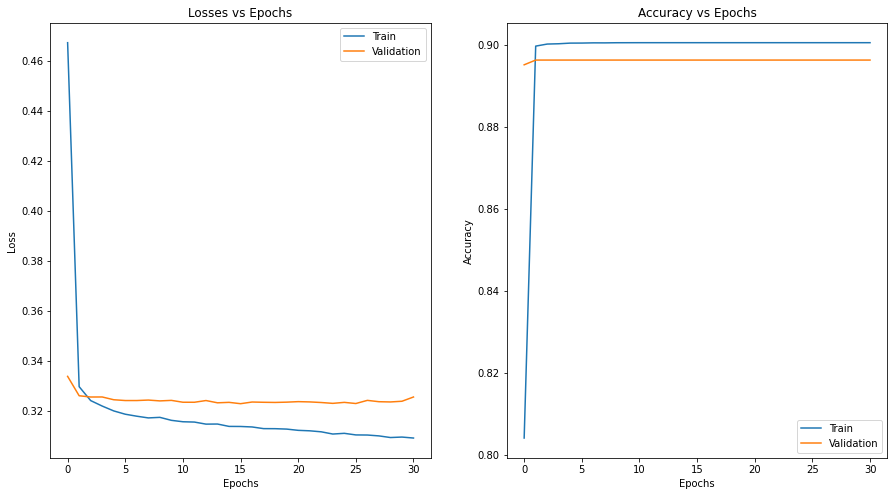

In [ ]:
draw_chart(tuned_history)

In [ ]:
tuned_model.evaluate(X_train, y_train)
tuned_model.evaluate(X_val, y_val)
tuned_model.evaluate(X_test, y_test)

678/678 [==============================] - 1s 1ms/step - loss: 0.3302 - accuracy: 0.9000


[0.3302094340324402, 0.8999723196029663]

### B.5.4 Confusion Matrix

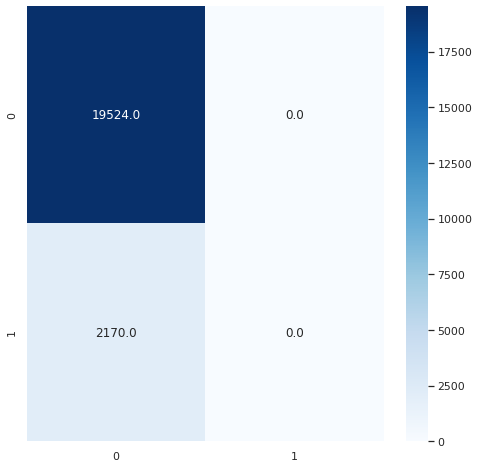

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_pred = tuned_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm_cnn = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,8))
sns.heatmap(cm_cnn, annot=True, 
            cmap='Blues', fmt='.1f')

### B.5.5. Scores of DNN Model

In [ ]:
# https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
# Accuracy: (TP + TN) / (P + N)
accuracy = accuracy_score(y_test, y_pred) # .round()
print('Accuracy: %f' % accuracy)
# Precision: TP / (TP + FP)
precision = precision_score(y_test, y_pred)
print('Precision of DNN Model: %f' % precision)
# Recall: TP / (TP + FN)
recall = recall_score(y_test, y_pred)
print('Recall DNN Model: %f' % recall)
# F1: 2 TP / (2 TP + FP + FN)
f1 = f1_score(y_test, y_pred)
print('F1-score DNN Model: %f' % f1)
print('Balanced accuracy of DNN Model: {:.2f} - Geometric mean of DNN Model: {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred),
              geometric_mean_score(y_test, y_pred)))

Accuracy: 0.899972
Precision of DNN Model: 0.000000
Recall DNN Model: 0.000000
F1-score DNN Model: 0.000000
Balanced accuracy of DNN Model: 0.50 - Geometric mean of DNN Model: 0.00


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tuned_model.save("/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro's Safer Driver Prediction/model_dnn")

## B.6 Distributed Random Forest H2O

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html

### B.6.1 Summary

In [ ]:
import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init()

# Import the cars dataset into H2O:
# cars = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/junit/cars_20mpg.csv")

# Set the predictors and response;
# set the response as a factor:
hf_train_file["target"] = hf_train_file["target"].asfactor()
predictors = X.columns.tolist()
response = "target"

# Split the dataset into a train and valid set:
train, valid = hf_train_file.split_frame(ratios=[.8], seed=1234)

# Build and train the model:
hf_train_file_drf = H2ORandomForestEstimator(ntrees=10,
                                    max_depth=5,
                                    min_rows=10,
                                    calibrate_model=True,
                                    calibration_frame=valid,
                                    binomial_double_trees=True)
hf_train_file_drf.train(x=predictors,
               y=response,
               training_frame=train,
               validation_frame=valid)

# Eval performance:
perf = hf_train_file_drf.model_performance()

# Generate predictions on a validation set (if necessary):
pred = hf_train_file_drf.predict(valid)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,5 mins 24 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_unknownUser_os9r65
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.869 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [ ]:
print(hf_train_file_drf.summary)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1598981279148_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,10.0,20.0,9099.0,5.0,5.0,5.0,29.0,32.0,31.6




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.08916599897611499
RMSE: 0.298606763111814
LogLoss: 0.32003463451246766
Mean Per-Class Error: 0.42689792184224207
AUC: 0.6011218987561718
AUCPR: 0.1404187560183176
Gini: 0.20224379751234367

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10328275148525204: 


,,0,1,Error,Rate
0,0,93574.0,61047.0,0.3948,(61047.0/154621.0)
1,1,7916.0,9318.0,0.4593,(7916.0/17234.0)
2,Total,101490.0,70365.0,0.4013,(68963.0/171855.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.103283,0.212742,248.0
1,max f2,0.075699,0.368283,336.0
2,max f0point5,0.137911,0.168827,147.0
3,max accuracy,0.389694,0.899724,3.0
4,max precision,0.389694,0.571429,3.0
5,max recall,0.025126,1.000000,399.0
6,max specificity,0.517241,0.999994,0.0
7,max absolute_mcc,0.111437,0.090045,221.0
8,max min_per_class_accuracy,0.100963,0.571475,255.0
9,max mean_per_class_accuracy,0.097455,0.573102,266.0



Gains/Lift Table: Avg response rate: 10.03 %, avg score:  9.91 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.187101,2.014981,2.014981,0.202073,0.215220,0.202073,0.215220,0.020157,0.020157,101.498107,101.498107,0.011285
1,2,0.020002,0.170442,2.096558,2.055758,0.210253,0.177787,0.206162,0.196509,0.020961,0.041119,109.655768,105.575763,0.023471
2,3,0.030005,0.161731,1.773872,1.961778,0.177893,0.165872,0.196737,0.186295,0.017745,0.058864,77.387222,96.177779,0.032075
3,4,0.040003,0.156086,1.769150,1.913635,0.177419,0.158969,0.191909,0.179465,0.017688,0.076552,76.915004,91.363472,0.040622
4,5,0.050001,0.151728,1.642782,1.859477,0.164747,0.153755,0.186478,0.174324,0.016425,0.092977,64.278218,85.947669,0.047765
5,6,0.100003,0.138445,1.473569,1.666523,0.147777,0.144368,0.167127,0.159346,0.073681,0.166657,47.356924,66.652296,0.074084
6,7,0.150004,0.130447,1.352973,1.562006,0.135683,0.134201,0.156646,0.150965,0.067651,0.234308,35.297316,56.200636,0.093700
7,8,0.200000,0.123805,1.273871,1.489979,0.127750,0.127040,0.149423,0.144984,0.063688,0.297996,27.387103,48.997875,0.108919
8,9,0.300003,0.112019,1.238120,1.406024,0.124165,0.117642,0.141003,0.135870,0.123816,0.421811,23.811975,40.602414,0.135386
9,10,0.400017,0.103499,1.068014,1.321513,0.107106,0.107448,0.132528,0.128764,0.106817,0.528628,6.801369,32.151301,0.142946




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.08806874434395472
RMSE: 0.2967637854320414
LogLoss: 0.31704941216882154
Mean Per-Class Error: 0.42692841456270203
AUC: 0.6005529428688353
AUCPR: 0.13815417010432543
Gini: 0.20110588573767063

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10584315575891248: 


,,0,1,Error,Rate
0,0,24808.0,14216.0,0.3643,(14216.0/39024.0)
1,1,2099.0,2182.0,0.4903,(2099.0/4281.0)
2,Total,26907.0,16398.0,0.3767,(16315.0/43305.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.105843,0.211035,235.0
1,max f2,0.075094,0.365545,352.0
2,max f0point5,0.145585,0.169114,113.0
3,max accuracy,0.288220,0.901143,1.0
4,max precision,0.288220,0.500000,1.0
5,max recall,0.062025,1.000000,397.0
6,max specificity,0.303559,0.999974,0.0
7,max absolute_mcc,0.105843,0.089473,235.0
8,max min_per_class_accuracy,0.100562,0.568727,254.0
9,max mean_per_class_accuracy,0.089830,0.573072,296.0



Gains/Lift Table: Avg response rate:  9.89 %, avg score: 10.01 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010022,0.182614,1.981171,1.981171,0.195853,0.200785,0.195853,0.200785,0.019855,0.019855,98.117122,98.117122,0.010912
1,2,0.020021,0.166596,2.125917,2.053461,0.210162,0.173406,0.202999,0.187112,0.021257,0.041112,112.591703,105.346065,0.023405
2,3,0.030020,0.158153,1.775491,1.960875,0.175520,0.162065,0.193846,0.178769,0.017753,0.058865,77.549115,96.087542,0.032009
3,4,0.040018,0.153141,1.892300,1.943741,0.187067,0.155516,0.192152,0.172959,0.018921,0.077786,89.229977,94.374140,0.041910
4,5,0.050017,0.149086,2.125917,1.980160,0.210162,0.151093,0.195753,0.168588,0.021257,0.099042,112.591703,98.015971,0.054403
5,6,0.100012,0.137656,1.266206,1.623265,0.125173,0.142709,0.160471,0.155651,0.063303,0.162345,26.620553,62.326504,0.069172
6,7,0.150006,0.129997,1.298912,1.515164,0.128406,0.133564,0.149784,0.148290,0.064938,0.227283,29.891194,51.516399,0.085755
7,8,0.200000,0.122951,1.224154,1.442420,0.121016,0.126459,0.142593,0.142833,0.061201,0.288484,22.415442,44.242000,0.098191
8,9,0.300058,0.112402,1.272333,1.385702,0.125779,0.117347,0.136986,0.134334,0.127307,0.415791,27.233252,38.570235,0.128429
9,10,0.400092,0.103845,1.123180,1.320064,0.111034,0.108035,0.130498,0.127759,0.112357,0.528148,12.318021,32.006424,0.142103




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-09-01 17:33:29,0.095 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-09-01 17:33:32,2.689 sec,1.0,0.296994,0.317959,0.589940,0.135326,1.868401,0.476159,0.297120,0.318097,0.589347,0.134959,2.236086,0.430897
2,,2020-09-01 17:33:34,4.232 sec,2.0,0.299017,0.321343,0.588942,0.134975,1.787957,0.446744,0.296871,0.317366,0.597396,0.136147,1.902779,0.381226
3,,2020-09-01 17:33:41,11.612 sec,10.0,0.298607,0.320035,0.601122,0.140419,2.014981,0.401286,0.296764,0.317049,0.600553,0.138154,1.981171,0.376746



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,ps_car_12 ps_car_15,429.612183,1.000000,0.140458
1,ps_car_13 ps_car_15,339.197632,0.789544,0.110898
2,ps_car_13^2,275.096161,0.640336,0.089940
3,ps_reg_01 ps_car_13,231.658600,0.539227,0.075739
4,ps_reg_02 ps_car_13,187.861847,0.437282,0.061420
5,ps_ind_17_bin,127.178253,0.296030,0.041580
6,ps_car_13,119.494781,0.278146,0.039068
7,ps_car_11_cat_te,114.261490,0.265964,0.037357
8,ps_reg_02,104.809006,0.243962,0.034266
9,ps_reg_03 ps_car_14,93.855797,0.218466,0.030685



See the whole table with table.as_data_frame()
<bound method ModelBase.summary of >


### B.6.2 Performance

In [ ]:
print(perf)


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.08916599897611499
RMSE: 0.298606763111814
LogLoss: 0.32003463451246766
Mean Per-Class Error: 0.42689792184224207
AUC: 0.6011218987561718
AUCPR: 0.1404187560183176
Gini: 0.20224379751234367

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10328275148525204: 


,,0,1,Error,Rate
0,0,93574.0,61047.0,0.3948,(61047.0/154621.0)
1,1,7916.0,9318.0,0.4593,(7916.0/17234.0)
2,Total,101490.0,70365.0,0.4013,(68963.0/171855.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.103283,0.212742,248.0
1,max f2,0.075699,0.368283,336.0
2,max f0point5,0.137911,0.168827,147.0
3,max accuracy,0.389694,0.899724,3.0
4,max precision,0.389694,0.571429,3.0
5,max recall,0.025126,1.000000,399.0
6,max specificity,0.517241,0.999994,0.0
7,max absolute_mcc,0.111437,0.090045,221.0
8,max min_per_class_accuracy,0.100963,0.571475,255.0
9,max mean_per_class_accuracy,0.097455,0.573102,266.0



Gains/Lift Table: Avg response rate: 10.03 %, avg score:  9.91 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.187101,2.014981,2.014981,0.202073,0.215220,0.202073,0.215220,0.020157,0.020157,101.498107,101.498107,0.011285
1,2,0.020002,0.170442,2.096558,2.055758,0.210253,0.177787,0.206162,0.196509,0.020961,0.041119,109.655768,105.575763,0.023471
2,3,0.030005,0.161731,1.773872,1.961778,0.177893,0.165872,0.196737,0.186295,0.017745,0.058864,77.387222,96.177779,0.032075
3,4,0.040003,0.156086,1.769150,1.913635,0.177419,0.158969,0.191909,0.179465,0.017688,0.076552,76.915004,91.363472,0.040622
4,5,0.050001,0.151728,1.642782,1.859477,0.164747,0.153755,0.186478,0.174324,0.016425,0.092977,64.278218,85.947669,0.047765
5,6,0.100003,0.138445,1.473569,1.666523,0.147777,0.144368,0.167127,0.159346,0.073681,0.166657,47.356924,66.652296,0.074084
6,7,0.150004,0.130447,1.352973,1.562006,0.135683,0.134201,0.156646,0.150965,0.067651,0.234308,35.297316,56.200636,0.093700
7,8,0.200000,0.123805,1.273871,1.489979,0.127750,0.127040,0.149423,0.144984,0.063688,0.297996,27.387103,48.997875,0.108919
8,9,0.300003,0.112019,1.238120,1.406024,0.124165,0.117642,0.141003,0.135870,0.123816,0.421811,23.811975,40.602414,0.135386
9,10,0.400017,0.103499,1.068014,1.321513,0.107106,0.107448,0.132528,0.128764,0.106817,0.528628,6.801369,32.151301,0.142946


### B.6.3 Prediction

In [ ]:
print(pred)

predict,p0,p1,cal_p0,cal_p1
0,0.907694,0.0923055,0.912662,0.0873384
1,0.866307,0.133693,0.865248,0.134752
0,0.922823,0.0771773,0.925848,0.0741525
1,0.88674,0.11326,0.890904,0.109096
1,0.890054,0.109946,0.894637,0.105363
0,0.932941,0.0670592,0.933618,0.0663818
0,0.925728,0.0742717,0.928161,0.0718391
1,0.892583,0.107417,0.897409,0.102591
1,0.890709,0.109291,0.895361,0.104639
0,0.902714,0.0972858,0.907876,0.0921238


In [ ]:
# retrieve the AUC for the performance object:
perf.auc()

0.6011218987561718

In [ ]:
# retrieve the AUC for both the training and validation data:
hf_train_file_drf.auc(train=True, valid=True, xval=False)

{'train': 0.6011218987561718, 'valid': 0.6005529428688353}

In [ ]:
# Predict the class probabilities using the GBM model and test data.
staged_predict_proba = hf_train_file_drf.staged_predict_proba(hf_test_file)

H2OResponseError: ignored

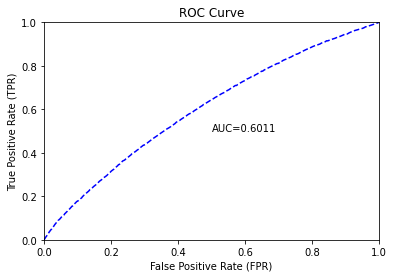

In [ ]:
perf.plot(type = "roc")

## B.7 Gradient Boosting H2O

### B.7.1 Summary

In [ ]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o.init()
h2o.cluster().show_status()

# import the covtype dataset:
# this dataset is used to classify the correct forest cover type
hf_train_file["target"] = hf_train_file["target"].asfactor()
predictors = X.columns.tolist()
response = "target"

# split into train and validation sets
train_gb, valid_gb = hf_train_file.split_frame(ratios = [.8], seed = 1234)

# try using the balance_classes parameter (set to True):
cov_gbm = H2OGradientBoostingEstimator(balance_classes = True, seed = 1234)
cov_gbm.train(x = predictors, y = response, training_frame = train_gb, validation_frame = valid_gb)

print('logloss', cov_gbm.logloss(valid = True))

# grid over `balance_classes` (boolean parameter)
# import Grid Search
from h2o.grid.grid_search import H2OGridSearch

# select the values for `balance_classes` to grid over
hyper_params = {'balance_classes': [True, False]}

# this example uses cartesian grid search because the search space is small
# and we want to see the performance of all models. For a larger search space use
# random grid search instead: {'strategy': "RandomDiscrete"}
# initialize the GBM estimator
cov_gbm_2 = H2OGradientBoostingEstimator(seed = 1234)

# build grid search with previously made GBM and hyperparameters
grid = H2OGridSearch(model = cov_gbm_2, hyper_params = hyper_params,
                     search_criteria = {'strategy': "Cartesian"})

# train using the grid
grid.train(x = predictors, y = response, training_frame = train_gb, validation_frame = valid_gb)

# sort the grid models by logloss
sorted_grid = grid.get_grid(sort_by='logloss', decreasing=False)
print(sorted_grid)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,17 mins 28 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_unknownUser_os9r65
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.812 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


H2O_cluster_uptime:,17 mins 28 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_unknownUser_os9r65
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.812 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


gbm Model Build progress: |███████████████████████████████████████████████| 100%
logloss 0.3126858556635803
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
    balance_classes  \
0             false   
1              true   

                                                       model_ids  \
0  Grid_GBM_py_12_sid_a365_model_python_1598981279148_55_model_2   
1  Grid_GBM_py_12_sid_a365_model_python_1598981279148_55_model_1   

               logloss  
0  0.31244279560038235  
1   0.3126858556635803  



In [ ]:
print(sorted_grid)

    balance_classes  \
0             false   
1              true   

                                                       model_ids  \
0  Grid_GBM_py_12_sid_a365_model_python_1598981279148_55_model_2   
1  Grid_GBM_py_12_sid_a365_model_python_1598981279148_55_model_1   

               logloss  
0  0.31244279560038235  
1   0.3126858556635803  



In [ ]:
cov_gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1598981279148_10


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22419.0,5.0,5.0,5.0,25.0,32.0,31.0




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.39149036906036316
RMSE: 0.6256919122542365
LogLoss: 1.1408349597166443
Mean Per-Class Error: 0.37570927055088266
AUC: 0.6740573380548194
AUCPR: 0.6731829016300585
Gini: 0.34811467610963875

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06597193734869071: 


,,0,1,Error,Rate
0,0,36524.0,119698.0,0.7662,(119698.0/156222.0)
1,1,13749.0,142501.0,0.088,(13749.0/156250.0)
2,Total,50273.0,262199.0,0.4271,(133447.0/312472.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.065972,0.681091,334.0
1,max f2,0.041907,0.834399,386.0
2,max f0point5,0.099651,0.624308,259.0
3,max accuracy,0.099651,0.624290,259.0
4,max precision,0.426954,1.000000,0.0
5,max recall,0.034675,1.000000,396.0
6,max specificity,0.426954,1.000000,0.0
7,max absolute_mcc,0.108140,0.249798,240.0
8,max min_per_class_accuracy,0.098214,0.620796,262.0
9,max mean_per_class_accuracy,0.099651,0.624291,259.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 10.84 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010001,0.263911,1.836635,1.836635,0.918400,0.300426,0.918400,0.300426,0.018368,0.018368,83.663542,83.663542,0.016736
1,2,0.020021,0.237543,1.714315,1.775416,0.857234,0.248782,0.887788,0.274579,0.017178,0.035546,71.431460,77.541636,0.031052
2,3,0.030009,0.221763,1.640994,1.730676,0.820570,0.229095,0.865415,0.259440,0.016390,0.051936,64.099361,73.067567,0.043858
3,4,0.040000,0.210032,1.575131,1.691824,0.787636,0.215532,0.845988,0.248473,0.015738,0.067674,57.513112,69.182376,0.055351
4,5,0.050001,0.201028,1.576819,1.668821,0.788480,0.205330,0.834485,0.239844,0.015770,0.083443,57.681870,66.882127,0.066890
5,6,0.100019,0.171945,1.480832,1.574812,0.740482,0.184865,0.787476,0.212350,0.074067,0.157510,48.083218,57.481169,0.114994
6,7,0.150026,0.154350,1.396777,1.515468,0.698451,0.162565,0.757802,0.195756,0.069850,0.227360,39.677744,51.546820,0.154681
7,8,0.200021,0.141042,1.292292,1.459686,0.646204,0.147320,0.729908,0.183649,0.064608,0.291968,29.229234,45.968584,0.183910
8,9,0.300001,0.122263,1.199854,1.373093,0.599981,0.131015,0.686608,0.166108,0.119962,0.411930,19.985407,37.309281,0.223877
9,10,0.400001,0.108668,1.095047,1.303582,0.547573,0.115107,0.651849,0.153358,0.109504,0.521434,9.504701,30.358191,0.242888




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.08722539145886551
RMSE: 0.29533945124020516
LogLoss: 0.3126858556635803
Mean Per-Class Error: 0.4050039427338912
AUC: 0.6312797740217534
AUCPR: 0.15752884275200094
Gini: 0.2625595480435068

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11816363929843933: 


,,0,1,Error,Rate
0,0,30387.0,8637.0,0.2213,(8637.0/39024.0)
1,1,2621.0,1660.0,0.6122,(2621.0/4281.0)
2,Total,33008.0,10297.0,0.26,(11258.0/43305.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.118164,0.227740,193.0
1,max f2,0.073967,0.376733,304.0
2,max f0point5,0.146817,0.189528,139.0
3,max accuracy,0.374071,0.901143,3.0
4,max precision,0.374071,0.500000,3.0
5,max recall,0.036831,1.000000,393.0
6,max specificity,0.397167,0.999974,0.0
7,max absolute_mcc,0.118164,0.116686,193.0
8,max min_per_class_accuracy,0.096178,0.591790,243.0
9,max mean_per_class_accuracy,0.098218,0.594996,238.0



Gains/Lift Table: Avg response rate:  9.89 %, avg score:  9.71 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010022,0.227989,2.773640,2.773640,0.274194,0.258511,0.274194,0.258511,0.027797,0.027797,177.363971,177.363971,0.019725
1,2,0.020021,0.206114,2.499705,2.636830,0.247113,0.215343,0.260669,0.236952,0.024994,0.052791,149.970464,163.683016,0.036366
2,3,0.030020,0.192172,2.196002,2.490001,0.217090,0.198556,0.246154,0.224163,0.021957,0.074749,119.600221,149.000054,0.049636
3,4,0.040018,0.182788,1.775491,2.311476,0.175520,0.187088,0.228505,0.214900,0.017753,0.092502,77.549115,131.147626,0.058241
4,5,0.050017,0.175022,1.705406,2.190318,0.168591,0.178887,0.216528,0.207700,0.017052,0.109554,70.540597,119.031817,0.066068
5,6,0.100012,0.150185,1.616631,1.903541,0.159815,0.161315,0.188178,0.184513,0.080822,0.190376,61.663141,90.354102,0.100278
6,7,0.150006,0.134732,1.481133,1.762760,0.146420,0.142005,0.174261,0.170346,0.074048,0.264424,48.113340,76.276016,0.126970
7,8,0.200000,0.124303,1.392359,1.670171,0.137644,0.129290,0.165108,0.160083,0.069610,0.334034,39.235885,67.017052,0.148738
8,9,0.300012,0.109104,1.174823,1.505042,0.116139,0.116239,0.148784,0.145467,0.117496,0.451530,17.482348,50.504213,0.168140
9,10,0.400000,0.098509,1.165750,1.420229,0.115242,0.103492,0.140399,0.134975,0.116562,0.568092,16.575011,42.022892,0.186532




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-09-01 17:45:31,0.025 sec,0.0,0.640162,1.202806,0.500000,0.500045,1.000000,0.499955,0.298473,0.322575,0.500000,0.098857,1.000000,0.901143
1,,2020-09-01 17:46:03,32.217 sec,7.0,0.636285,1.181877,0.633946,0.629378,1.696876,0.468448,0.296887,0.317453,0.612053,0.146672,2.528907,0.326544
2,,2020-09-01 17:46:13,42.337 sec,10.0,0.634891,1.175765,0.639630,0.634004,1.689064,0.458105,0.296541,0.316341,0.615629,0.147727,2.551486,0.366886
3,,2020-09-01 17:46:20,49.048 sec,12.0,0.634054,1.172286,0.643137,0.637518,1.692747,0.451058,0.296319,0.315652,0.619155,0.150163,2.727024,0.371874
4,,2020-09-01 17:46:26,55.920 sec,14.0,0.633309,1.169300,0.645837,0.640412,1.708380,0.444859,0.296146,0.315147,0.620839,0.152392,2.843563,0.354370
5,,2020-09-01 17:46:33,1 min 2.557 sec,16.0,0.632599,1.166492,0.648422,0.643709,1.743844,0.440612,0.295999,0.314694,0.622954,0.153766,2.794500,0.340838
6,,2020-09-01 17:46:43,1 min 12.406 sec,19.0,0.631643,1.163025,0.650628,0.647685,1.746250,0.439883,0.295871,0.314307,0.623946,0.153893,2.796948,0.351553
7,,2020-09-01 17:46:50,1 min 19.246 sec,21.0,0.631031,1.160788,0.652424,0.649791,1.749604,0.455980,0.295782,0.314036,0.625077,0.154496,2.790518,0.301097
8,,2020-09-01 17:46:56,1 min 25.797 sec,23.0,0.630466,1.158679,0.654573,0.652014,1.767967,0.438250,0.295714,0.313814,0.625946,0.154704,2.727024,0.315414
9,,2020-09-01 17:47:03,1 min 32.241 sec,25.0,0.629982,1.156845,0.656536,0.654391,1.780173,0.442785,0.295671,0.313691,0.626249,0.155284,2.820256,0.325644



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,ps_car_11_cat_te,3484.061279,1.000000,0.096238
1,ps_ind_03,2929.698730,0.840886,0.080925
2,ps_ind_17_bin,2428.832520,0.697127,0.067090
3,ps_car_13,2117.113037,0.607657,0.058480
4,ps_ind_15,1460.435059,0.419176,0.040341
5,ps_car_13^2,1291.965698,0.370822,0.035687
6,ps_ind_05_cat_6.0,1235.729492,0.354681,0.034134
7,ps_car_07_cat_1.0,1200.827881,0.344663,0.033170
8,ps_reg_02 ps_car_13,1146.297852,0.329012,0.031664
9,ps_reg_03 ps_car_13,1085.685913,0.311615,0.029989



See the whole table with table.as_data_frame()


In [ ]:
# Predict the class probabilities using the GBM model and test data.
staged_predict_proba = cov_gbm.staged_predict_proba(hf_test_file)

In [ ]:
staged_predict_proba

T1.C1,T2.C1,T3.C1,T4.C1,T5.C1,T6.C1,T7.C1,T8.C1,T9.C1,T10.C1,T11.C1,T12.C1,T13.C1,T14.C1,T15.C1,T16.C1,T17.C1,T18.C1,T19.C1,T20.C1,T21.C1,T22.C1,T23.C1,T24.C1,T25.C1,T26.C1,T27.C1,T28.C1,T29.C1,T30.C1,T31.C1,T32.C1,T33.C1,T34.C1,T35.C1,T36.C1,T37.C1,T38.C1,T39.C1,T40.C1,T41.C1,T42.C1,T43.C1,T44.C1,T45.C1,T46.C1,T47.C1,T48.C1,T49.C1,T50.C1
0.905913,0.907005,0.90977,0.911769,0.91314,0.915936,0.917256,0.916037,0.917356,0.919105,0.921277,0.91974,0.921882,0.923851,0.922513,0.923244,0.923642,0.923924,0.924449,0.925632,0.92425,0.924717,0.92521,0.925545,0.925983,0.926365,0.925361,0.925564,0.925883,0.926052,0.926216,0.925352,0.924788,0.925114,0.925975,0.925906,0.926318,0.92592,0.925765,0.926333,0.926377,0.926336,0.926933,0.927043,0.927411,0.92761,0.927043,0.927261,0.927546,0.927252
0.903414,0.904532,0.907363,0.90941,0.910814,0.913678,0.913629,0.916248,0.916606,0.916908,0.91774,0.917946,0.916254,0.917153,0.917739,0.919013,0.91943,0.919726,0.921367,0.921383,0.922786,0.923282,0.922501,0.922847,0.922152,0.922552,0.923527,0.924906,0.925227,0.925398,0.926201,0.928456,0.930302,0.930385,0.929858,0.929793,0.929747,0.929365,0.929217,0.928762,0.930687,0.930707,0.930643,0.930748,0.930404,0.930596,0.931521,0.931726,0.931489,0.931609
0.903536,0.9026,0.902131,0.901589,0.903101,0.902096,0.903611,0.903151,0.902353,0.904386,0.906912,0.907143,0.907677,0.907731,0.908377,0.909371,0.909833,0.910161,0.910773,0.912149,0.912182,0.911806,0.911632,0.912023,0.910339,0.910794,0.911903,0.912139,0.91251,0.912984,0.913174,0.913951,0.914836,0.915461,0.915346,0.91591,0.915855,0.916448,0.916764,0.917394,0.918167,0.918191,0.918849,0.91897,0.919269,0.919602,0.920079,0.920316,0.920626,0.920763
0.903536,0.904652,0.904192,0.908784,0.912041,0.91112,0.911071,0.913255,0.912532,0.912847,0.913716,0.914077,0.914008,0.91291,0.913371,0.914181,0.914621,0.914721,0.914413,0.91443,0.915909,0.916423,0.915579,0.915954,0.915201,0.915634,0.91691,0.917609,0.917959,0.917488,0.917669,0.917718,0.917675,0.918411,0.919341,0.919266,0.919712,0.92028,0.920583,0.921005,0.921053,0.921009,0.920936,0.921055,0.921347,0.921561,0.921826,0.922059,0.921791,0.921926
0.903536,0.904652,0.904192,0.90366,0.905143,0.904158,0.904105,0.903647,0.902852,0.903198,0.904153,0.904389,0.902448,0.901218,0.901905,0.90092,0.90142,0.900439,0.900084,0.900105,0.900142,0.899719,0.898725,0.899166,0.89828,0.898789,0.900032,0.898264,0.898686,0.898911,0.899129,0.899188,0.899137,0.899253,0.899119,0.899027,0.898963,0.899661,0.900034,0.899411,0.899471,0.899499,0.899409,0.899557,0.89992,0.900186,0.898605,0.898899,0.898561,0.898732
0.905913,0.907005,0.911978,0.909853,0.90836,0.903375,0.904872,0.903269,0.903678,0.900741,0.899117,0.895059,0.897786,0.896012,0.898136,0.89514,0.895667,0.89519,0.896729,0.898298,0.896907,0.896472,0.899018,0.894166,0.896509,0.894051,0.895616,0.895891,0.894932,0.895164,0.896256,0.896316,0.892311,0.892762,0.89262,0.892524,0.8931,0.891835,0.892233,0.893028,0.893091,0.893122,0.893957,0.892766,0.893151,0.893433,0.894048,0.894353,0.894752,0.894929
0.897722,0.89441,0.891395,0.893754,0.895372,0.895204,0.896813,0.898275,0.895789,0.897944,0.900622,0.900047,0.902659,0.902553,0.902682,0.90704,0.907253,0.907589,0.907598,0.909019,0.908449,0.909027,0.910491,0.910886,0.911099,0.911551,0.911623,0.91186,0.912232,0.912852,0.913777,0.91455,0.914545,0.914912,0.915472,0.916035,0.914139,0.914742,0.916253,0.916888,0.917665,0.917877,0.918537,0.918658,0.918959,0.919753,0.920229,0.920466,0.920775,0.920456
0.903414,0.897489,0.902917,0.907564,0.91086,0.913722,0.913674,0.9158,0.917123,0.917422,0.91825,0.916532,0.919334,0.921362,0.918033,0.926186,0.92657,0.926657,0.925224,0.925239,0.926546,0.927001,0.926402,0.926732,0.925872,0.926255,0.924292,0.92534,0.92566,0.92583,0.926628,0.927745,0.927367,0.928022,0.927958,0.927548,0.927951,0.928465,0.927347,0.927737,0.926845,0.926804,0.926737,0.925514,0.925889,0.926092,0.925736,0.925288,0.92503,0.92516
0.903536,0.897482,0.896991,0.892088,0.893728,0.892638,0.893912,0.891384,0.888793,0.888641,0.889722,0.887

### B.7.2 Performance

In [ ]:
# Eval performance:
perf_gbm = cov_gbm.model_performance()

# Generate predictions on a test set (if necessary):
pred_gbm = cov_gbm.predict(hf_train_file)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [ ]:
# retrieve the AUC for the performance object:
perf_gbm.auc()

0.6740573380548194

### B.7.3 Prediction

In [ ]:
pred_gbm

predict,p0,p1
0,0.892602,0.107398
0,0.909249,0.0907512
1,0.868848,0.131152
0,0.91712,0.0828795
0,0.955331,0.0446686
0,0.926904,0.0730959
0,0.912628,0.087372
0,0.927763,0.0722372
0,0.884861,0.115139
0,0.882893,0.117107


In [ ]:
# retrieve the AUC for both the training and validation data:
cov_gbm.auc(train=True, valid=True, xval=False)

{'train': 0.6740573380548194, 'valid': 0.6312797740217534}

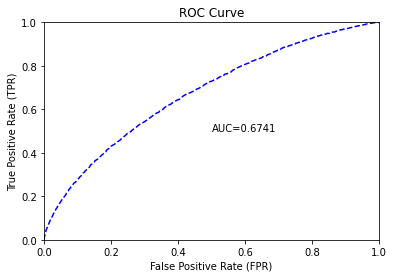

In [ ]:
perf_gbm.plot(type = "roc")

# C. Draw Feature Importance

Permutation Importance with Multicollinear or Correlated Features:

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

Permutation Importance vs Random Forest Feature Importance (MDI):

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

In [ ]:
import seaborn as sns
def drawFeatureImportance(model, title, n_top):
  importances = pd.DataFrame({'feature': X_train.columns,'importance':np.round(model.best_estimator_.feature_importances_,3)}) # https://stackoverflow.com/questions/47111434/randomforestregressor-and-feature-importances-error
  importances = importances.sort_values('importance', ascending=False).head(n_top)
  plt.figure(figsize=(15,5))
  sns.barplot(y=importances['feature'], x=importances['importance']).set_title(title)

## C.1. Feature Importance of Single Decision Tree

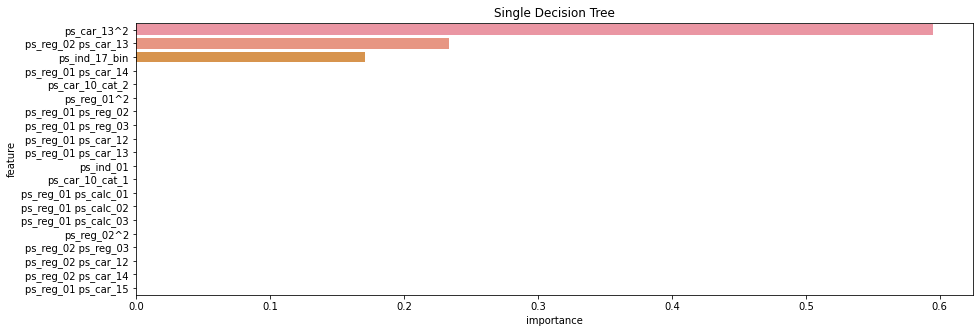

In [ ]:
drawFeatureImportance(rs_decision_tree, 'Single Decision Tree', 20)

## C.2. Feature Importance of Random Forest

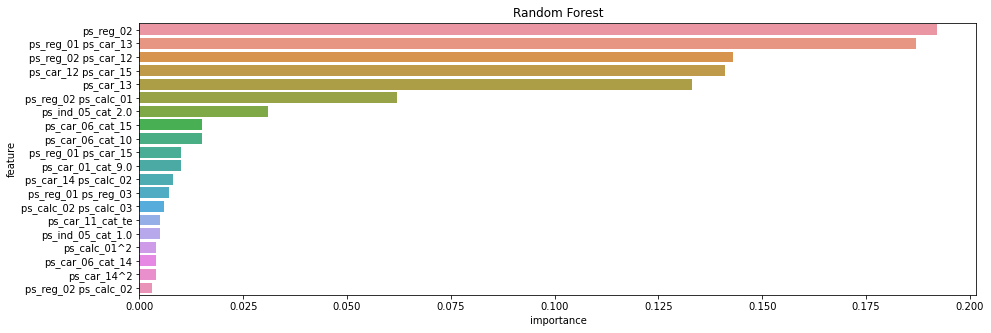

In [ ]:
drawFeatureImportance(rs_rf, 'Random Forest', 20)

## C.3. Feature Importance of Balanced Random Forest

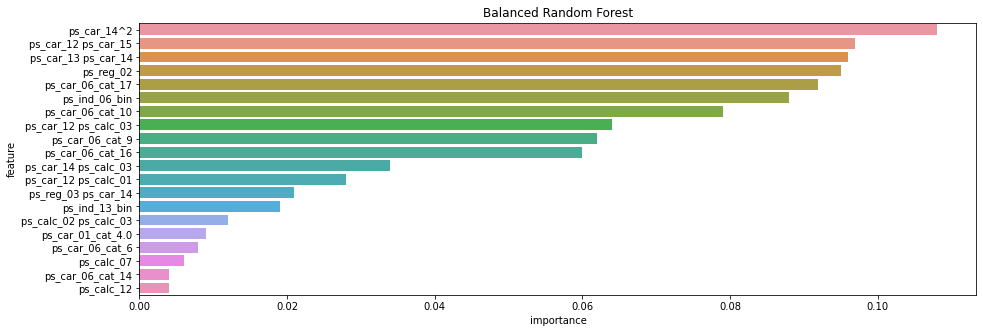

In [ ]:
drawFeatureImportance(rs_brf, 'Balanced Random Forest', 20)

## C.4. Feature Importance of RUS Boost

In [ ]:
drawFeatureImportance(rs_rusboost, 'RUS Boost', 20)

## C.5. Feature Importance of XGBoost

In [ ]:
drawFeatureImportance(rs_xgboost, 'XGBoost', 20)

Comments: 

# D. Heatmap

In [ ]:
sns.heatmap(df_train.corr(), cmap="Spectral")

# E. Draw Tree

In [ ]:
pip install --upgrade scikit-learn==0.20.3

In [ ]:
# https://www.kaggle.com/hamelg/python-for-data-29-decision-trees
# https://www.kdnuggets.com/2020/04/visualizing-decision-trees-python.html
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# draw tree
def drawTree(model):
  dot_data = StringIO()
  export_graphviz(model, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True,
                  feature_names = X_train.columns,
                  class_names=[str(x) for x in model.classes_]
                  )
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
  return graph.create_png()

## E.1 Tree of Single Decision Tree

In [ ]:
Image(drawTree(best_decision_tree))

# F. ROC & AUC between Deep Neural Network, Ensemble Classifiers XGBoost Classifier

In [ ]:
decisiontree_probs = best_decision_tree.predict_proba(X_val)[:, 1]
decisiontree_probs

array([0.10519131, 0.12488372, 0.07438424, ..., 0.12488372, 0.07438424,
       0.07438424])

In [ ]:
# ROC & AUC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# pred_proba = model.predict_proba(X_val)
# print('AUC: ' + str(roc_auc_score(y_val, pred_proba[:,1])))

# Probs:
nomodel_probs = [0 for _ in range(len(y_val))]

best_mlp_probs = tuned_model.predict(X_val_scaled)[:, 0]

decisiontree_probs = best_decision_tree.predict_proba(X_val)[:, 1]
bagging_probs = best_bagging.predict_proba(X_val)[:, 1]
balanced_bagging_probs = best_balanced_bagging.predict_proba(X_val)[:, 1]
randomforest_probs = best_rf.predict_proba(X_val)[:, 1]
balanced_randomforest_probs = best_brf.predict_proba(X_val)[:, 1]
xgboost_probs = best_xgboost.predict_proba(X_val)[:, 1]
eec_probs = best_eec.predict_proba(X_val)[:, 1]
rusboost_probs = best_rusboost.predict_proba(X_val)[:, 1]

best_probs = [x for x in y_val]

# AUC: 
nomodel_auc = roc_auc_score(y_val, nomodel_probs)
mlp_auc = roc_auc_score(y_val, best_mlp_probs)

decisiontree_auc = roc_auc_score(y_val, decisiontree_probs)
bagging_auc = roc_auc_score(y_val, bagging_probs)
balanced_bagging_auc = roc_auc_score(y_val, balanced_bagging_probs)
randomforest_auc = roc_auc_score(y_val, randomforest_probs)
balanced_randomforest_auc = roc_auc_score(y_val, balanced_randomforest_probs)
eec_auc = roc_auc_score(y_val, eec_probs)
rusboost_auc = roc_auc_score(y_val, rusboost_probs)
xgboost_auc = roc_auc_score(y_val, xgboost_probs)
best_auc = roc_auc_score(y_val, best_probs)

# Summarize scores:
print('No Skill: ROC AUC=%.3f' % (nomodel_auc))
print('With MLP: ROC AUC=%.3f' % (mlp_auc))
print('With Decision Tree: ROC AUC=%.3f' % (decisiontree_auc))
print('With Bagging: ROC AUC=%.3f' % (bagging_auc))
print('With Balanced Bagging: ROC AUC=%.3f' % (balanced_bagging_auc))
print('With Random Forest: ROC AUC=%.3f' % (randomforest_auc))
print('With Balanced Random Forest: ROC AUC=%.3f' % (balanced_randomforest_auc))
print('With Easy Ensemble: ROC AUC=%.3f' % (eec_auc))
print('With RUS Boost: ROC AUC=%.3f' % (rusboost_auc))
print('With XGBoost: ROC AUC=%.3f' % (xgboost_auc))
print('Best: ROC AUC=%.3f' % (best_auc))

In [ ]:
# Calculate ROC Curves
nomodel_fpr, nomodel_tpr, _ = roc_curve(y_val, nomodel_probs)
mlp_fpr, mlp_tpr, _ = roc_curve(y_val, best_mlp_probs)
decisiontree_fpr, decisiontree_tpr, _ = roc_curve(y_val, decisiontree_probs)
bagging_fpr, bagging_tpr, _ = roc_curve(y_val, bagging_probs)
balanced_bagging_fpr, balanced_bagging_tpr, _ = roc_curve(y_val, balanced_bagging_probs)
randomforest_fpr, randomforest_tpr, _ = roc_curve(y_val, randomforest_probs)
balanced_randomforest_fpr, balanced_randomforest_tpr, _ = roc_curve(y_val, balanced_randomforest_probs)
eec_fpr, eec_tpr, _ = roc_curve(y_val, eec_probs)
rusboost_fpr, rusboost_tpr, _ = roc_curve(y_val, rusboost_probs)
xgboost_fpr, xgboost_tpr, _ = roc_curve(y_val, xgboost_probs)
best_fpr, best_tpr, _ = roc_curve(y_val, best_probs)

plt.figure(figsize=(10,10))
# plot the roc curve for the model
plt.plot(nomodel_fpr, nomodel_tpr, linestyle=':',linewidth=3, label='No Model')

plt.plot(mlp_fpr, mlp_tpr, marker='x', label='MLP')
plt.plot(decisiontree_fpr, decisiontree_tpr, marker='x', label='Decision Tree')
plt.plot(bagging_fpr, bagging_tpr, marker='x', label='Bagging Classifier')
plt.plot(balanced_bagging_fpr, balanced_bagging_tpr, marker='x', label='Balanced Bagging Classifier')
plt.plot(randomforest_fpr, randomforest_tpr, marker='x', label='Random Forest')
plt.plot(balanced_randomforest_fpr, balanced_randomforest_tpr, marker='x', label='Balanced Random Forest')
plt.plot(eec_fpr, eec_tpr, marker='x', label='Easy Ensemble Classifier')
plt.plot(rusboost_fpr, rusboost_tpr, marker='x', label='RUS Boost')
plt.plot(xgboost_fpr, xgboost_tpr, marker='x', label='XGBoost Classifier')
plt.plot(best_fpr, best_tpr, linestyle=':', label='Best')

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show the legend
plt.legend()

# Show the plot
plt.show()

# G. Predict

In [ ]:
df_test_pred = df_test_merge

In [ ]:
# Từ model tính predict sẽ ra 0 1
predict = best_rusboost.predict(df_test_pred) # df test merge
predict

In [ ]:
predict = pd.DataFrame({'id': df_test.index, 'target': predict}) # raw df_test
predict.head()

In [ ]:
predict = predict.merge(df_test_pred,on='id') # df test merge
predict.head(5)

# H. New Policy on Trial

## H.1 List out

In [ ]:
predict[predict['target'] == 1].shape

In [ ]:
new_policy = predict.copy(True)
new_policy = new_policy.drop(columns=['target'])
new_policy = new_policy.drop(columns=['id'])

## H.2 Implement that New Policy

In [ ]:
print('Duration unique values: ', df_test_pred['duration'].unique()) # df test merge

In [ ]:
new_policy

In [ ]:
df_test_pred.head()

In [ ]:
new_policy['duration'] = 200
result = best_decision_tree.predict(new_policy)
len(np.where(result==1)[0])

In [ ]:
new_policy['duration'] = 150
result = best_decision_tree.predict(new_policy)
len(np.where(result==1)[0])

## H.3 Result

# Selecting features with a Random Forest and SelectFromModel

Here we'll base feature selection on the feature importances of a random forest. With Sklearn's SelectFromModel you can then specify how many variables you want to keep. You can set a threshold on the level of feature importance manually. But we'll simply select the top 50% best variables.

The code in the cell below is borrowed from the GitHub repo of Sebastian Raschka. This repo contains code samples of his book Python Machine Learning, which is an absolute must to read.

In [ ]:
# X_train = train.drop(['id', 'target'], axis=1)
# y_train = train['target']

# feat_labels = X_train.columns

# rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# rf.fit(X_train, y_train)
# importances = rf.feature_importances_

# indices = np.argsort(rf.feature_importances_)[::-1]

# for f in range(X_train.shape[1]):
#     print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

With SelectFromModel we can specify which prefit classifier to use and what the threshold is for the feature importances. With the get_support method we can then limit the number of variables in the train data.

In [ ]:
# sfm = SelectFromModel(rf, threshold='median', prefit=True)
# print('Number of features before selection: {}'.format(X_train.shape[1]))
# n_features = sfm.transform(X_train).shape[1]
# print('Number of features after selection: {}'.format(n_features))
# selected_vars = list(feat_labels[sfm.get_support()])

In [ ]:
# train = train[selected_vars + ['target']]

# Feature scaling (no need)

As mentioned before, we can apply standard scaling to the training data. Some classifiers perform better when this is done.

In [ ]:
# scaler = StandardScaler()
# scaler.fit_transform(train.drop(['target'], axis=1))